In [35]:
import pandas as pd
import os
af_pdb_rmsd_10=pd.read_csv("Proteome_RMSD_AF-PDB_pairs_10.txt",sep='\t') # proteins with atleast 10 structures
af_pdb_rmsd_L10=pd.read_csv("Proteome_RMSD_AF-PDB_pairs_less10.txt",sep='\t') # proteins with <10 structures

af_pdb_rmsd=pd.concat([af_pdb_rmsd_10,af_pdb_rmsd_L10])


#################################################################################################################

paired_df=pd.read_csv("paired_df_str_NPall.txt",sep='\t')
p_np_df=pd.read_csv(os.path.join('PDB_phospho_data','pdbDF_newP_NP.txt'),sep='\t')


In [2]:
# Extract PDB IDs and Chain IDs from prot1 and prot2 in af_pdb_rmsd
af_pdb_rmsd['PDBID_1'] = af_pdb_rmsd['prot1'].str.split('__').str[0]
af_pdb_rmsd['CHAINID_1'] = af_pdb_rmsd['prot1'].str.split('__').str[1]
af_pdb_rmsd['PDBID_2'] = af_pdb_rmsd['prot2'].str.split('__').str[0]
af_pdb_rmsd['CHAINID_2'] = af_pdb_rmsd['prot2'].str.split('__').str[1]

# Merge af_pdb_rmsd with p_np_df to get P_status1 for prot1
af_pdb_rmsd = pd.merge(
    af_pdb_rmsd, 
    p_np_df[['PDBID', 'CHAINID', 'P_status']], 
    left_on=['PDBID_1', 'CHAINID_1'], 
    right_on=['PDBID', 'CHAINID'], 
    how='left'
).rename(columns={'P_status': 'P_status1'})

# Merge af_pdb_rmsd with p_np_df again to get P_status2 for prot2
af_pdb_rmsd = pd.merge(
    af_pdb_rmsd, 
    p_np_df[['PDBID', 'CHAINID', 'P_status']], 
    left_on=['PDBID_2', 'CHAINID_2'], 
    right_on=['PDBID', 'CHAINID'], 
    how='left'
).rename(columns={'P_status': 'P_status2'})

# Drop the temporary columns used for merging
af_pdb_rmsd = af_pdb_rmsd.drop(['PDBID_x', 'CHAINID_x','PDBID_y', 'CHAINID_y',\
                               'PDBID_1','CHAINID_1','PDBID_2','CHAINID_2'], axis=1)

# Check the result
af_pdb_rmsd.head()


,ACC_ID,prot1,prot2,TM_RMSD,PDBsup_RMSD,P_status1,P_status2
0,O14920,4kik__A,4e3c__D,2.12,2.73,P,NP
1,O14920,4kik__A,4e3c__C,2.31,2.82,P,NP
2,O14920,4kik__A,8omv__C,2.46,2.50,P,NP
3,O14920,4kik__A,4kik__B,1.75,2.36,P,P
4,O14920,4kik__A,8omv__D,2.19,2.13,P,NP


### Filtering 

In [4]:


# Filter for rows where either prot1 or prot2 contains 'AF-' or 'AF3'
af_filtered_df = af_pdb_rmsd[
    af_pdb_rmsd['prot1'].str.contains("AF-|AF3") | af_pdb_rmsd['prot2'].str.contains("AF-|AF3")
].copy()

def is_in_paired_df(row, paired_df):
    # Extract PDBID and CHAINID from prot1 and prot2
    prot1_pdb_chain = row['prot1'].split('__')[0] + "__" + row['prot1'].split('__')[1]
    prot2_pdb_chain = row['prot2'].split('__')[0] + "__" + row['prot2'].split('__')[1]
    
    # Check if prot1 or prot2 matches either PDBID_1/CHAINID_1 or PDBID_2/CHAINID_2 in paired_df
    prot1_match = any((paired_df['PDBID_1'] == row['prot1'].split('__')[0]) & (paired_df['CHAINID_1'] == row['prot1'].split('__')[1])) \
               or any((paired_df['PDBID_2'] == row['prot1'].split('__')[0]) & (paired_df['CHAINID_2'] == row['prot1'].split('__')[1]))
    
    prot2_match = any((paired_df['PDBID_1'] == row['prot2'].split('__')[0]) & (paired_df['CHAINID_1'] == row['prot2'].split('__')[1])) \
               or any((paired_df['PDBID_2'] == row['prot2'].split('__')[0]) & (paired_df['CHAINID_2'] == row['prot2'].split('__')[1]))
    
    return prot1_match or prot2_match

# Apply the function to filter the rows
af_filtered_df = af_filtered_df[af_filtered_df.apply(is_in_paired_df, axis=1, paired_df=paired_df)]



In [5]:
af_filtered_df.loc[af_filtered_df.ACC_ID=='P07949'].head()

,ACC_ID,prot1,prot2,TM_RMSD,PDBsup_RMSD,P_status1,P_status2
127958,P07949,6vhg__A,P07949_AF3__A,1.43,1.79,P,NaN
127961,P07949,6vhg__A,AF-P07949-F1-model_v4__A,1.43,1.77,P,NaN
127962,P07949,6vhg__A,P07949_AF3_905_928__A,1.51,2.11,P,NaN
127988,P07949,7du8__A,AF-P07949-F1-model_v4__A,1.61,2.09,NP,NaN
128009,P07949,7du8__A,P07949_AF3_905_928__A,1.12,1.32,NP,NaN


In [6]:
def classify_model_type(row):
    if 'F1-model_v4' in row['prot1'] or 'F1-model_v4' in row['prot2']:
        return 'AF2'
    elif 'AF3__A' in row['prot1'] or 'AF3__A' in row['prot2']:
        return 'AF3'
    else:
        return 'AF3-p'

# Apply the function to create the Model_Type column
af_filtered_df['Model_Type'] = af_filtered_df.apply(classify_model_type, axis=1)


# Verify the result
af_filtered_df.head()


,ACC_ID,prot1,prot2,TM_RMSD,PDBsup_RMSD,P_status1,P_status2,Model_Type
10,O14920,4kik__A,O14920_AF3_257__A,1.28,1.68,P,NaN,AF3-p
13,O14920,4kik__A,AF-O14920-F1-model_v4__A,1.73,2.26,P,NaN,AF2
17,O14920,4kik__A,O14920_AF3__A,1.18,1.74,P,NaN,AF3
19,O14920,O14920_AF3_257__A,4e3c__A,2.15,2.67,NaN,NP,AF3-p
21,O14920,AF-O14920-F1-model_v4__A,8omv__A,2.28,2.29,NaN,NP,AF2


### Get the predictions that are very close and diverse to the experimental conformers based on RMSD

In [8]:
# Function to find two min and two max RMSD rows for a given ACC_ID, Model_Type, and P_status
def get_two_min_max_rmsd_rows(df, acc_id, model_type, p_status):
    # Filter by ACC_ID, Model_Type, and P_status
    filtered_df = df[
        (df['ACC_ID'] == acc_id) & 
        (df['Model_Type'] == model_type) & 
        ((df['P_status1'] == p_status) | (df['P_status2'] == p_status))
    ]

    if filtered_df.empty:
        return None, None

    # Sort by RMSD in ascending order to get the smallest values
    min_rmsd_rows = filtered_df.nsmallest(1, 'PDBsup_RMSD').copy()
    min_rmsd_rows['fold_label'] = 'minimum'  # Add fold label for minimum

    # Sort by RMSD in descending order to get the largest values
    max_rmsd_rows = filtered_df.nlargest(1, 'PDBsup_RMSD').copy()
    max_rmsd_rows['fold_label'] = 'maximum'  # Add fold label for maximum

    return min_rmsd_rows, max_rmsd_rows

# Initialize an empty list to store results
results = []

# Loop over each ACC_ID (protein) and model type (AF2, AF3, AF3-p)
for acc_id in af_filtered_df['ACC_ID'].unique():
    for model_type in af_filtered_df['Model_Type'].unique():
        # Find two min and two max for P status
        min_rmsd_p, max_rmsd_p = get_two_min_max_rmsd_rows(af_filtered_df, acc_id, model_type, 'P')

        # Find two min and two max for NP status
        min_rmsd_np, max_rmsd_np = get_two_min_max_rmsd_rows(af_filtered_df, acc_id, model_type, 'NP')

        # Append results (if any) to the list
        if min_rmsd_p is not None:
            results.append(min_rmsd_p)
            results.append(max_rmsd_p)
        if min_rmsd_np is not None:
            results.append(min_rmsd_np)
            results.append(max_rmsd_np)

# Combine all results into a final dataframe
rmsd_summary = pd.concat(results)

# Create a new column 'PDB_status' based on the values of 'P_status1' and 'P_status2'
rmsd_summary['PDB_status'] = rmsd_summary.apply(
    lambda row: row['P_status1'] if pd.notna(row['P_status1']) else row['P_status2'],
    axis=1
)

# Select only the relevant columns
rmsd_summary = rmsd_summary[['ACC_ID', 'prot1', 'prot2', 'PDBsup_RMSD', 'PDB_status', 'Model_Type', 'fold_label']]

# Verify the result
rmsd_summary.head()


,ACC_ID,prot1,prot2,PDBsup_RMSD,PDB_status,Model_Type,fold_label
10,O14920,4kik__A,O14920_AF3_257__A,1.68,P,AF3-p,minimum
10,O14920,4kik__A,O14920_AF3_257__A,1.68,P,AF3-p,maximum
25,O14920,O14920_AF3_257__A,8omv__A,2.27,NP,AF3-p,minimum
19,O14920,O14920_AF3_257__A,4e3c__A,2.67,NP,AF3-p,maximum
13,O14920,4kik__A,AF-O14920-F1-model_v4__A,2.26,P,AF2,minimum


In [9]:
rmsd_summary.loc[(rmsd_summary.ACC_ID=='P07949')]

,ACC_ID,prot1,prot2,PDBsup_RMSD,PDB_status,Model_Type,fold_label
128138,P07949,6i82__A,P07949_AF3_905_928__A,1.65,P,AF3-p,minimum
127962,P07949,6vhg__A,P07949_AF3_905_928__A,2.11,P,AF3-p,maximum
128093,P07949,7ju5__B,P07949_AF3_905_928__A,1.30,NP,AF3-p,minimum
128198,P07949,6nec__A,P07949_AF3_905_928__A,1.49,NP,AF3-p,maximum
128166,P07949,5fm3__A,AF-P07949-F1-model_v4__A,1.74,P,AF2,minimum
128247,P07949,6nja__A,AF-P07949-F1-model_v4__A,2.38,P,AF2,maximum
128270,P07949,2ivs__A,AF-P07949-F1-model_v4__A,1.97,NP,AF2,minimum
128196,P07949,6nec__A,AF-P07949-F1-model_v4__A,2.10,NP,AF2,maximum
128163,P07949,5fm3__A,P07949_AF3__A,1.77,P,AF3,minimum
128239,P07949,6nja__A,P07949_AF3__A,2.42,P,AF3,maximum


In [10]:
# Filter for AF-to-AF pairs (both prot1 and prot2 contain "AF") from the original af_pdb_rmsd dataframe
af_to_af_rmsd = af_pdb_rmsd[af_pdb_rmsd['prot1'].str.contains('AF') & af_pdb_rmsd['prot2'].str.contains('AF')]

# Check the result
af_to_af_rmsd.head()


,ACC_ID,prot1,prot2,TM_RMSD,PDBsup_RMSD,P_status1,P_status2
29,O14920,O14920_AF3_257__A,O14920_AF3__A,2.29,12.24,NaN,NaN
30,O14920,O14920_AF3_257__A,AF-O14920-F1-model_v4__A,2.25,13.79,NaN,NaN
31,O14920,AF-O14920-F1-model_v4__A,O14920_AF3__A,2.28,10.85,NaN,NaN
193,O14939,O14939_AF3_573__A,AF-O14939-F1-model_v4__A,2.03,5.04,NaN,NaN
194,O14939,O14939_AF3_573__A,O14939_AF3__A,1.75,3.80,NaN,NaN


In [11]:
# Combine the closest and farthest RMSD values with the AF-to-AF data
combined_rmsd_df = pd.concat([rmsd_summary, af_to_af_rmsd[['ACC_ID', 'prot1', 'prot2', 'PDBsup_RMSD']]])

# Verify the result
combined_rmsd_df.head()


,ACC_ID,prot1,prot2,PDBsup_RMSD,PDB_status,Model_Type,fold_label
10,O14920,4kik__A,O14920_AF3_257__A,1.68,P,AF3-p,minimum
10,O14920,4kik__A,O14920_AF3_257__A,1.68,P,AF3-p,maximum
25,O14920,O14920_AF3_257__A,8omv__A,2.27,NP,AF3-p,minimum
19,O14920,O14920_AF3_257__A,4e3c__A,2.67,NP,AF3-p,maximum
13,O14920,4kik__A,AF-O14920-F1-model_v4__A,2.26,P,AF2,minimum


In [12]:
combined_rmsd_df.loc[combined_rmsd_df.ACC_ID=='P07949']

,ACC_ID,prot1,prot2,PDBsup_RMSD,PDB_status,Model_Type,fold_label
128138,P07949,6i82__A,P07949_AF3_905_928__A,1.65,P,AF3-p,minimum
127962,P07949,6vhg__A,P07949_AF3_905_928__A,2.11,P,AF3-p,maximum
128093,P07949,7ju5__B,P07949_AF3_905_928__A,1.30,NP,AF3-p,minimum
128198,P07949,6nec__A,P07949_AF3_905_928__A,1.49,NP,AF3-p,maximum
128166,P07949,5fm3__A,AF-P07949-F1-model_v4__A,1.74,P,AF2,minimum
128247,P07949,6nja__A,AF-P07949-F1-model_v4__A,2.38,P,AF2,maximum
128270,P07949,2ivs__A,AF-P07949-F1-model_v4__A,1.97,NP,AF2,minimum
128196,P07949,6nec__A,AF-P07949-F1-model_v4__A,2.10,NP,AF2,maximum
128163,P07949,5fm3__A,P07949_AF3__A,1.77,P,AF3,minimum
128239,P07949,6nja__A,P07949_AF3__A,2.42,P,AF3,maximum


In [36]:
# Function to extract the MODPOS from prot names
import re
def extract_modpos(prot):
    match = re.search(r'_AF3_(\d+(_\d+)*)', prot)
    if match:
        return match.group(1).replace('_', ',')  # Extract and format positions
    return None

# Function to assign MODPOS for each ACC_ID
def assign_modpos_for_acc_id(group):
    # Extract MODPOS from any prot1 or prot2 in the group
    modpos = None
    for _, row in group.iterrows():
        modpos = extract_modpos(row['prot1']) or extract_modpos(row['prot2'])
        if modpos:
            break  # Stop once we find the MODPOS
    
    # Assign the same MODPOS to all rows within this ACC_ID group
    group['MODPOS_UP'] = modpos
    return group

# Apply the function to each ACC_ID group
combined_rmsd_new = combined_rmsd_df.groupby('ACC_ID').apply(assign_modpos_for_acc_id)


### Map the modified positions between PDB residue numbers to UniProt positions

In [39]:
# Load the PDB map dataframes
upmapped_p = pd.read_csv('UPmapped_P.txt', sep='\t', names=['PDBID', 'CHAINID', 'PDBRES', 'PDBPOS', 'ACC_ID', 'UPRES', 'UPPOS'])
upmapped_np = pd.read_csv('UPmapped_NP.txt', sep='\t', names=['PDBID', 'CHAINID', 'PDBRES', 'PDBPOS', 'ACC_ID', 'UPRES', 'UPPOS'])




# Function to split the PDB info and map positions
def map_pdb_positions(row, mapped_df, column_name):
    pdb_id = None
    chain_id = None
    
    # Check if prot1 or prot2 is PDB and extract PDBID, CHAINID
    if "AF" not in row[column_name]:
        pdb_id, chain_id = row[column_name].split('__')
    else:
        return None  # No PDB structure
    
    # Split MODPOS_UP into individual positions
    modpos_up_list = row['MODPOS_UP'].split(',')
    
    # Map each MODPOS_UP to the corresponding PDBPOS
    pdb_positions = []
    for modpos in modpos_up_list:
        mapped_row = mapped_df[(mapped_df['PDBID'] == pdb_id) & 
                               (mapped_df['CHAINID'] == chain_id) & 
                               (mapped_df['UPPOS'] == int(modpos))]
        
        if not mapped_row.empty:
            pdb_positions.append(str(mapped_row['PDBPOS'].values[0]))
        else:
            pdb_positions.append("NaN")  # If no match, return NaN
    
    # Return PDBPOS as a comma-separated string in the same order
    return ','.join(pdb_positions)

# Apply the mapping for each row based on PDB_status and assign to PDBPOS_1 and PDBPOS_2
def map_pdbpos_for_row(row):
    if "AF" not in row['prot1'] and "AF" not in row['prot2']:  # Neither is AF (both PDB)
        return pd.Series([None, None])  # No mapping needed for PDB-PDB pairs
    
    elif "AF" not in row['prot1']:  # prot1 is the PDB entry
        # Map prot1 using PDB mappings
        if row['PDB_status'] == 'P':
            pdbpos_1 = map_pdb_positions(row, upmapped_p, 'prot1')
        elif row['PDB_status'] == 'NP':
            pdbpos_1 = map_pdb_positions(row, upmapped_np, 'prot1')
        else:
            pdbpos_1 = None
        
        pdbpos_2 = row['MODPOS_UP']  # For AF model, MODPOS_UP is the same as PDBPOS
        
    elif "AF" not in row['prot2']:  # prot2 is the PDB entry
        # Map prot2 using PDB mappings
        if row['PDB_status'] == 'P':
            pdbpos_2 = map_pdb_positions(row, upmapped_p, 'prot2')
        elif row['PDB_status'] == 'NP':
            pdbpos_2 = map_pdb_positions(row, upmapped_np, 'prot2')
        else:
            pdbpos_2 = None
        
        pdbpos_1 = row['MODPOS_UP']  # For AF model, MODPOS_UP is the same as PDBPOS
    
    else:  # Both prot1 and prot2 are AF models
        pdbpos_1 = row['MODPOS_UP']
        pdbpos_2 = row['MODPOS_UP']  # AF vs AF case: PDBPOS_1 and PDBPOS_2 are the same
    
    return pd.Series([pdbpos_1, pdbpos_2])

# Apply the function to all rows and assign the results to new columns
combined_rmsd_new[['PDBPOS_1', 'PDBPOS_2']] = combined_rmsd_new.apply(map_pdbpos_for_row, axis=1)

# Save the final result if needed
# combined_rmsd_new.to_csv("combined_rmsd_with_pdbpos.txt", sep='\t', index=False)



### generate structure pairs per protein

In [17]:
import pandas as pd
import re
from itertools import combinations

# Sample DataFrame
rmsd_df = pd.read_csv('RMSD_clustering_infile.txt', sep='\t')
finaldf=rmsd_df.copy()


# Function to process each protein (ACC_ID) group
def process_protein_group(group_df):
    # Extract unique PDB and AF entries
    pdb_entries = set(group_df['prot1']).union(set(group_df['prot2']))
    pdb_entries = [pdb for pdb in pdb_entries if not any(x in pdb for x in ['F1-model_v4', 'AF3'])]
    af_entries = [af for af in set(group_df['prot1']).union(set(group_df['prot2'])) if any(x in af for x in ['F1-model_v4', 'AF3'])]

    # Initialize a list for new rows
    new_rows = []

    # Generate all possible combinations of PDB-PDB
    for comb in combinations(pdb_entries, 2):
        # Check if the combination is present in the original data
        if not (
            ((group_df['prot1'] == comb[0]) & (group_df['prot2'] == comb[1])).any() or
            ((group_df['prot1'] == comb[1]) & (group_df['prot2'] == comb[0])).any()
        ):
            # If not present, get PDBPOS_1 and PDBPOS_2 values from the first occurrence of prot1 and prot2
            prot1_row = group_df[(group_df['prot1'] == comb[0]) | (group_df['prot2'] == comb[0])]
            prot2_row = group_df[(group_df['prot1'] == comb[1]) | (group_df['prot2'] == comb[1])]
            
            # Ensure both rows exist before proceeding
            if not prot1_row.empty and not prot2_row.empty:
                pdbpos_1 = prot1_row.iloc[0]['PDBPOS_1']
                pdbpos_2 = prot2_row.iloc[0]['PDBPOS_2']
                
                new_rows.append({
                    'ACC_ID': prot1_row.iloc[0]['ACC_ID'],
                    'prot1': comb[0],
                    'prot2': comb[1],
                    'PDBPOS_1': pdbpos_1,
                    'PDBPOS_2': pdbpos_2
                })

    # Add PDB-AF and AF-PDB combinations
    for prot_pdb in pdb_entries:
        for prot_af in af_entries:
            if not (
                ((group_df['prot1'] == prot_pdb) & (group_df['prot2'] == prot_af)).any() or
                ((group_df['prot1'] == prot_af) & (group_df['prot2'] == prot_pdb)).any()
            ):
                # Extract PDBPOS for the PDB entry
                pdb_row = group_df[(group_df['prot1'] == prot_pdb) | (group_df['prot2'] == prot_pdb)]
                
                if not pdb_row.empty:
                    pdbpos_1 = pdb_row.iloc[0]['PDBPOS_1']
                    pdbpos_2 = pdb_row.iloc[0]['PDBPOS_2']
                    
                    new_rows.append({
                        'ACC_ID': pdb_row.iloc[0]['ACC_ID'],
                        'prot1': prot_pdb,
                        'prot2': prot_af,
                        'PDBPOS_1': pdbpos_1,
                        'PDBPOS_2': pdbpos_2
                    })

    return new_rows

# Process the dataframe grouped by ACC_ID
all_new_rows = []
for acc_id, group_df in finaldf.groupby('ACC_ID'):
    new_rows = process_protein_group(group_df)
    all_new_rows.extend(new_rows)

# Convert the new rows to a DataFrame
new_df = pd.DataFrame(all_new_rows)

# Remove duplicate (flipped) combinations
new_df['sorted_pair'] = new_df.apply(lambda row: tuple(sorted([row['prot1'], row['prot2']])), axis=1)
new_df = new_df.drop_duplicates(subset='sorted_pair').drop(columns='sorted_pair')

final_rmsd_df=pd.concat([finaldf,new_df])

final_rmsd_df.to_csv("RMSD_Foldintact_clustering_infile.txt",sep='\t',index=False)


rmsd_new.to_csv('RMSD_clustering_infile.txt',sep='\t',index=False)

## Perform TM align, PDB Superpose and get RMSD between pairs 
(PDB-PDB, PDB-AF, AF-AF)

In [178]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from Bio.PDB import PDBParser, Superimposer
from Bio.PDB import PDBList
import subprocess, math, requests, time
from threading import Lock

# Directories for PDB and AF models
PDB_DIRECTORY = 'PDB_Files'
AF2_DIRECTORY = 'AF_models/Human_AF2'
AF3_DIRECTORY = 'AF_PDB_models'
os.makedirs(PDB_DIRECTORY, exist_ok=True)
os.makedirs(AF2_DIRECTORY, exist_ok=True)
os.makedirs(AF3_DIRECTORY, exist_ok=True)

# Locks for thread-safe file operations
download_lock = Lock()
chain_lock = Lock()

# Caches to track downloaded PDBs and extracted chains/segments
downloaded_pdbs = set()
extracted_chains = set()
extracted_segments = set()

def process_prot_pair(prot1, prot2):
    """Extract PDBID and CHAINID from prot1 and prot2."""
    PDBID_1, CHAINID_1 = prot1.split("__")
    PDBID_2, CHAINID_2 = prot2.split("__")
    return PDBID_1, CHAINID_1, PDBID_2, CHAINID_2

def check_af_model(PDBID):
    """Check if the model is AF2 or AF3."""
    if "F1-model_v4" in PDBID:
        return "AF2"
    elif "AF3" in PDBID:
        return "AF3"
    else:
        return "PDB"

def get_pdb_file(PDBID, model_type, directory=PDB_DIRECTORY, retries=3, wait_time=5):
    """Get the PDB file path, download if necessary, and cache the downloaded files."""
    if model_type == "PDB":
        pdb_file_final = os.path.join(directory, f"{PDBID}.pdb")
        
        with download_lock:  # Ensure thread-safe access to downloading
            # Skip download if already processed
            if pdb_file_final in downloaded_pdbs or os.path.exists(pdb_file_final):
                downloaded_pdbs.add(pdb_file_final)
                return pdb_file_final

            # Try downloading if not already downloaded
            url = f"https://files.rcsb.org/download/{PDBID}.pdb"
            for attempt in range(retries):
                try:
                    response = requests.get(url, timeout=10)
                    if response.status_code == 200:
                        with open(pdb_file_final, 'wb') as pdb_file:
                            pdb_file.write(response.content)
                        downloaded_pdbs.add(pdb_file_final)  # Cache the downloaded file
                        return pdb_file_final
                except requests.exceptions.RequestException as e:
                    print(f"Error downloading PDB {PDBID}: {e}")
                time.sleep(wait_time)
            print(f"Failed to download PDB file {PDBID} after {retries} attempts.")
            return None
    
    elif model_type == "AF2":
        return os.path.join(AF2_DIRECTORY, f"{PDBID}.pdb")
    
    elif model_type == "AF3":
        return os.path.join(AF3_DIRECTORY, f"fold_{PDBID.lower()}_model_0.pdb")

def extract_chain_and_segments(PDBID, CHAINID, pdbfile, positions):
    """Extract chains and segments from PDB, using cache to avoid redundant extractions."""
    chain_output_file = os.path.join(PDB_DIRECTORY, f"{PDBID}_{CHAINID}.pdb")
    segment_output_file = chain_output_file.replace(".pdb", "_seg.pdb")
    
    with chain_lock:  # Ensure thread-safe access to chain extraction
        # Skip chain extraction if already processed
        if (PDBID, CHAINID) in extracted_chains:
            return chain_output_file, segment_output_file

        # Extract chain
        command = f"pdb_selchain -{CHAINID} {pdbfile} > {chain_output_file}"
        subprocess.run(command, shell=True, check=True)
    
        # Extract segments around positions
        segments = [(int(float(p)) - 15, int(float(p)) + 15) for p in positions.split(",") if p and p != 'nan' and not math.isnan(float(p))]
        residue_selection = ",".join(f"{start}:{end}" for start, end in segments)
        command = f"pdb_selres -{residue_selection} {chain_output_file} > {segment_output_file}"
        subprocess.run(command, shell=True, check=True)
    
        # Cache the extracted chain and segment
        extracted_chains.add((PDBID, CHAINID))
        extracted_segments.add((PDBID, CHAINID))
    
    return chain_output_file, segment_output_file

def extract_ca_atoms_with_residues(structure, chain_id):
    """Extract CA atoms and their residue numbers from the structure."""
    ca_atoms = []
    for model in structure:
        for chain in model:
            if chain.id == chain_id:
                for residue in chain:
                    if 'CA' in residue:
                        ca_atoms.append((residue['CA'], residue.id[1]))
    return ca_atoms

def get_mapped_residues_pdb(mapping_df, pdb_chain_atoms, map_to='UPPOS'):
    """Map CA atoms using the mapping file."""
    mapping_df1=mapping_df.copy()
    mapping_df1['PDBPOS'] = mapping_df1['PDBPOS'].astype('Int64')
    mapping_df1['UPPOS'] = mapping_df1['UPPOS'].astype('Int64')
    mapping_dict = mapping_df1.set_index('PDBPOS')[map_to].to_dict()
    mapped_atoms = [(atom, res_num, mapping_dict[res_num]) for atom, res_num in pdb_chain_atoms if res_num in mapping_dict]
    return mapped_atoms

def get_mapped_residues_af(pdb_chain_atoms):
    """Map CA atoms for AF models."""
    return [(atom, res_num, res_num) for atom, res_num in pdb_chain_atoms]

def run_tmalign(pdb1, pdb2):
    """Run TM-align between two PDB chain files."""
    command = f"TMalign {pdb1} {pdb2}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        raise Exception(f"TM-align failed: {stderr.decode().strip()}")
    return stdout.decode()

def parse_tmalign_output(output):
    """Parse TM-align output to extract RMSD and TM-score."""
    tm_rmsd = None
    tm_score = None
    for line in output.splitlines():
        if line.startswith("Aligned length="):
            tm_rmsd = float(line.split(',')[1].split()[1])
        elif line.startswith("TM-score=") and "if normalized by length of Chain_1" in line:
            tm_score = round(float(line.split('=')[1].split()[0]), 2)
    return tm_rmsd, tm_score


upmapped_p=pd.read_csv('UPmapped_P.txt',sep='\t',low_memory=False,header=None)
upmapped_np=pd.read_csv('UPmapped_NP.txt',sep='\t',low_memory=False,header=None)
mappingfile=pd.concat([upmapped_p,upmapped_np])
mappingfile.columns = ['PDBID', 'CHAINID', 'PDBRES', 'PDBPOS', 'ACC_ID', 'UPRES', 'UPPOS']

def load_mapping_file(pdbid, chainid, acc_id):
    pdbid=pdbid.split('_')[0]
#     print ("loading mapping file for", pdbid, chainid, acc_id)
#     print (mappingfile.head())
    mapdf=mappingfile.loc[(mappingfile.ACC_ID==acc_id)&(mappingfile.PDBID==pdbid)&(mappingfile.CHAINID==chainid)]
#     print (mapdf.head())
    return mapdf

def superimpose_structures(pdbfile1, pdbfile2, chain1, chain2, acc_id, map_to='UPPOS'):
    """Perform structure superposition using common CA atoms."""
    parser = PDBParser(QUIET=True)
    
    # Parse structures
    structure1 = parser.get_structure('structure1', pdbfile1)
    structure2 = parser.get_structure('structure2', pdbfile2)
    
    # Extract CA atoms
    ca_atoms1 = extract_ca_atoms_with_residues(structure1, chain1)
    ca_atoms2 = extract_ca_atoms_with_residues(structure2, chain2)
    
    # Map residues based on model type
    pdbid1 = pdbfile1.split('/')[-1].split('.')[0]
    pdbid2 = pdbfile2.split('/')[-1].split('.')[0]
    
    if 'F1-model_v4' in pdbid1 or 'AF3' in pdbid1:
        mapped_atoms1 = get_mapped_residues_af(ca_atoms1)  # AF model
    else:
        mapping1 = load_mapping_file(pdbid1, chain1, acc_id)
        mapped_atoms1 = get_mapped_residues_pdb(mapping1, ca_atoms1, map_to)
    
    if 'F1-model_v4' in pdbid2 or 'AF3' in pdbid2:
        mapped_atoms2 = get_mapped_residues_af(ca_atoms2)  # AF model
    else:
        mapping2 = load_mapping_file(pdbid2, chain2, acc_id)
        mapped_atoms2 = get_mapped_residues_pdb(mapping2, ca_atoms2, map_to)

    # Find common CA atoms based on mapped positions (UPPOS)
    common_ca_atoms1 = []
    common_ca_atoms2 = []
    for atom1, res_num1, uppos1 in mapped_atoms1:
        for atom2, res_num2, uppos2 in mapped_atoms2:
            if uppos1 == uppos2:
                common_ca_atoms1.append(atom1)
                common_ca_atoms2.append(atom2)
                break

    if len(common_ca_atoms1) == 0 or len(common_ca_atoms2) == 0:
        raise ValueError(f"No common residues found between {pdbfile1} and {pdbfile2} for alignment.")

    super_imposer = Superimposer()
    super_imposer.set_atoms(common_ca_atoms1, common_ca_atoms2)
    super_imposer.apply(structure2.get_atoms())  # Apply the transformation

    return super_imposer.rms  # Return RMSD

# Continue with other parts of the processing...


def process_pair(row):
    """Process a pair of structures."""
    acc_id = row['ACC_ID']
    
    prot1, prot2 = row['prot1'], row['prot2']
    print ("Processing protein pair", acc_id, prot1, prot2)
    PDBPOS_1, PDBPOS_2 = row['PDBPOS_1'], row['PDBPOS_2']
    
    PDBID_1, CHAINID_1, PDBID_2, CHAINID_2 = process_prot_pair(prot1, prot2)
    model_type_1 = check_af_model(PDBID_1)
    model_type_2 = check_af_model(PDBID_2)
    
    pdbfile1 = get_pdb_file(PDBID_1, model_type_1)
    pdbfile2 = get_pdb_file(PDBID_2, model_type_2)
    
    # Extract global chain and segment files
    chainfile1, segfile1 = extract_chain_and_segments(PDBID_1, CHAINID_1, pdbfile1, PDBPOS_1)
    chainfile2, segfile2 = extract_chain_and_segments(PDBID_2, CHAINID_2, pdbfile2, PDBPOS_2)
    
    # Perform TM-align on global chains
    tmalign_output_global = run_tmalign(chainfile1, chainfile2)
    rmsd_tm_global, tmscore_tm_global = parse_tmalign_output(tmalign_output_global)
    
    # Perform superimposition for global chains
    rmsd_superpose_global = superimpose_structures(chainfile1, chainfile2, CHAINID_1, CHAINID_2, acc_id)

    # Perform TM-align on segments
    tmalign_output_segment = run_tmalign(segfile1, segfile2)
    rmsd_tm_segment, tmscore_tm_segment = parse_tmalign_output(tmalign_output_segment)
    
    # Perform superimposition for segments
    rmsd_superpose_segment = superimpose_structures(segfile1, segfile2, CHAINID_1, CHAINID_2, acc_id)

    return {
        'acc_id': acc_id,
        'prot1': f'{PDBID_1}__{CHAINID_1}',
        'prot2': f'{PDBID_2}__{CHAINID_2}',
        'rmsd_tm_global': "{:.2f}".format(rmsd_tm_global),
        'tmscore_tm_global': "{:.2f}".format(tmscore_tm_global),
        'rmsd_superpose_global': "{:.2f}".format(rmsd_superpose_global),
        'rmsd_tm_segment': "{:.2f}".format(rmsd_tm_segment),
        'tmscore_tm_segment': "{:.2f}".format(tmscore_tm_segment),
        'rmsd_superpose_segment': "{:.2f}".format(rmsd_superpose_segment)
    }

def write_rmsd_to_file(results, filename="RMSD_AFPDB_final_clustering.txt"):
    """Write RMSD results to a file."""
    with open(filename, 'a') as f:
        f.write(f"ACC_ID\tprot1\tprot2\trmsd_type\tTM_rmsd\tTM_score\tPDB_rmsd\n")
        for result in results:
            f.write(f"{result['acc_id']}\t{result['prot1']}\t{result['prot2']}\tglobal\t{result['rmsd_tm_global']}\t{result['tmscore_tm_global']}\t{result['rmsd_superpose_global']}\n")
            f.write(f"{result['acc_id']}\t{result['prot1']}\t{result['prot2']}\tsegment\t{result['rmsd_tm_segment']}\t{result['tmscore_tm_segment']}\t{result['rmsd_superpose_segment']}\n")

def main_processing_rmsd(rmsd_df):
    """Main processing function for RMSD dataframe."""
    results = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pair, row) for idx, row in rmsd_df.iterrows()]
        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing pair: {e}")
    
    write_rmsd_to_file(results)

# Example usage
rmsd_df = pd.read_csv("RMSD_Foldintact_clustering_infile.txt", sep='\t')
print ("Total protein pairs", rmsd_df.shape[0])
# rmsd_df = rmsd_df[rmsd_df.ACC_ID == 'P01112']

main_processing_rmsd(rmsd_df)


Total protein pairs 2550
Processing protein pair O14920 4kik__A O14920_AF3_257__A
Processing protein pair O14920 4kik__A O14920_AF3_257__A
Processing protein pair O14920 O14920_AF3_257__A 8omv__A
Processing protein pair O14920 O14920_AF3_257__A 4e3c__A
Processing protein pair O14920 4kik__A AF-O14920-F1-model_v4__A
Processing protein pair O14920 4kik__A AF-O14920-F1-model_v4__A
Processing protein pair O14920 AF-O14920-F1-model_v4__A 8omv__A
Processing protein pair O14920 AF-O14920-F1-model_v4__A 4e3c__A
Processing protein pair O14920 4kik__A O14920_AF3__A
Processing protein pair O14920 4kik__A O14920_AF3__A
Processing protein pair O14920 O14920_AF3__A 8omv__A
Processing protein pair O14920 O14920_AF3__A 4e3c__A
Processing protein pair O14939 O14939_AF3_573__A 6ohp__A
Processing protein pair O14939 O14939_AF3_573__A 6ohp__A
Processing protein pair O14939 6ohm__B O14939_AF3_573__A
Processing protein pair O14939 O14939_AF3_573__A 6ohq__B
Processing protein pair O14939 6ohp__A AF-O14939-F1

Processing protein pair O75531 O75531_AF3__A 7abm__A
Processing protein pair O75531 O75531_AF3__A 7ndy__A
Processing protein pair O75531 O75531_AF3__A 6rpr__D
Processing protein pair O75531 O75531_AF3__A 2ezz__A
Processing protein pair O75533 O75533_AF3_129__A 7dvq__1
Processing protein pair O75533 O75533_AF3_129__A 7dvq__1
Processing protein pair O75533 O75533_AF3_129__A 5z58__1
Processing protein pair O75533 O75533_AF3_129__A 5z58__1
Processing protein pair O75533 AF-O75533-F1-model_v4__A 7dvq__1
Processing protein pair O75533 AF-O75533-F1-model_v4__A 7dvq__1
Processing protein pair O75533 AF-O75533-F1-model_v4__A 5z58__1
Processing protein pair O75533 AF-O75533-F1-model_v4__A 5z58__1
Processing protein pair O75533 O75533_AF3__A 7dvq__1
Processing protein pair O75533 O75533_AF3__A 7dvq__1
Processing protein pair O75533 O75533_AF3__A 5z58__1
Processing protein pair O75533 O75533_AF3__A 5z58__1
Processing protein pair O94804 6hxf__B O94804_AF3_185_191_208__A
Processing protein pair O94

Processing protein pair P06239 2of2__A AF-P06239-F1-model_v4__A
Processing protein pair P06239 P06239_AF3__A 1qpc__A
Processing protein pair P06239 P06239_AF3__A 1qpc__A
Processing protein pair P06239 P06239_AF3__A 2of4__A
Processing protein pair P06239 P06239_AF3__A 2pl0__A
Processing protein pair P06276 2y1k__A P06276_AF3_226__A
Processing protein pair P06276 2y1k__A P06276_AF3_226__A
Processing protein pair P06276 6qaa__A P06276_AF3_226__A
Processing protein pair P06276 P06276_AF3_226__A 6i2t__A
Processing protein pair P06276 AF-P06276-F1-model_v4__A 2y1k__A
Processing protein pair P06276 AF-P06276-F1-model_v4__A 2y1k__A
Processing protein pair P06276 AF-P06276-F1-model_v4__A 7bo3__A
Processing protein pair P06276 AF-P06276-F1-model_v4__A 6i2t__A
Processing protein pair P06276 2y1k__A P06276_AF3__A
Processing protein pair P06276 2y1k__A P06276_AF3__A
Processing protein pair P06276 P06276_AF3__A 7bo3__A
Processing protein pair P06276 P06276_AF3__A 6i2t__A
Processing protein pair P064

Processing protein pair P12931 1yi6__A AF-P12931-F1-model_v4__A
Processing protein pair P12931 8jn8__A AF-P12931-F1-model_v4__A
Processing protein pair P12931 1y57__A AF-P12931-F1-model_v4__A
Processing protein pair P12931 P12931_AF3__A 1fmk__A
Processing protein pair P12931 P12931_AF3__A 1yi6__A
Processing protein pair P12931 P12931_AF3__A 8jn8__A
Processing protein pair P12931 P12931_AF3__A 1y57__A
Processing protein pair P21802 P21802_AF3_561_586__A 6v6q__A
Processing protein pair P21802 8e1x__A P21802_AF3_561_586__A
Processing protein pair P21802 5ugx__A P21802_AF3_561_586__A
Processing protein pair P21802 4j96__B P21802_AF3_561_586__A
Processing protein pair P21802 AF-P21802-F1-model_v4__A 6v6q__A
Processing protein pair P21802 AF-P21802-F1-model_v4__A 8e1x__A
Processing protein pair P21802 AF-P21802-F1-model_v4__A 4j96__B
Processing protein pair P21802 AF-P21802-F1-model_v4__A 4j98__A
Processing protein pair P21802 P21802_AF3__A 6agx__B
Processing protein pair P21802 P21802_AF3__

Processing protein pair P35557 P35557_AF3_411__A 3imx__A
Processing protein pair P35557 1v4t__A P35557_AF3_411__A
Processing protein pair P35557 3qic__A AF-P35557-F1-model_v4__A
Processing protein pair P35557 3qic__A AF-P35557-F1-model_v4__A
Processing protein pair P35557 AF-P35557-F1-model_v4__A 7t78__A
Processing protein pair P35557 1v4t__A AF-P35557-F1-model_v4__A
Processing protein pair P35557 3qic__A P35557_AF3__A
Processing protein pair P35557 3qic__A P35557_AF3__A
Processing protein pair P35557 P35557_AF3__A 3imx__A
Processing protein pair P35557 P35557_AF3__A 1v4t__A
Processing protein pair P35968 2oh4__A P35968_AF3_1054_1059__A
Processing protein pair P35968 2oh4__A P35968_AF3_1054_1059__A
Processing protein pair P35968 2xir__A P35968_AF3_1054_1059__A
Processing protein pair P35968 4agc__A P35968_AF3_1054_1059__A
Processing protein pair P35968 2oh4__A AF-P35968-F1-model_v4__A
Processing protein pair P35968 2oh4__A AF-P35968-F1-model_v4__A
Processing protein pair P35968 2xir__A

Processing protein pair P52333 P52333_AF3__A 5ttv__A
Processing protein pair P54646 P54646_AF3_172__A 6b1u__A
Processing protein pair P54646 5ezv__A P54646_AF3_172__A
Processing protein pair P54646 P54646_AF3_172__A 5iso__A
Processing protein pair P54646 P54646_AF3_172__A 5iso__A
Processing protein pair P54646 AF-P54646-F1-model_v4__A 6b1u__A
Processing protein pair P54646 5ezv__A AF-P54646-F1-model_v4__A
Processing protein pair P54646 AF-P54646-F1-model_v4__A 5iso__A
Processing protein pair P54646 AF-P54646-F1-model_v4__A 5iso__A
Processing protein pair P54646 P54646_AF3__A 6b1u__A
Processing protein pair P54646 5ezv__A P54646_AF3__A
Processing protein pair P54646 P54646_AF3__A 5iso__A
Processing protein pair P54646 P54646_AF3__A 5iso__A
Processing protein pair P61006 P61006_AF3_111__A 6rir__A
Processing protein pair P61006 P61006_AF3_111__A 6stf__A
Processing protein pair P61006 P61006_AF3_111__A 6yx5__A
Processing protein pair P61006 4lhx__A P61006_AF3_111__A
Processing protein pair

Processing protein pair Q14653 AF-Q14653-F1-model_v4__A 1qwt__A
Processing protein pair Q14653 3a77__A Q14653_AF3__A
Processing protein pair Q14653 7jfl__A Q14653_AF3__A
Processing protein pair Q14653 Q14653_AF3__A 5jek__A
Processing protein pair Q14653 1qwt__A Q14653_AF3__A
Processing protein pair Q15022 Q15022_AF3_583__A 7td5__C
Processing protein pair Q15022 Q15022_AF3_583__A 7td5__C
Processing protein pair Q15022 Q15022_AF3_583__A 7at8__C
Processing protein pair Q15022 Q15022_AF3_583__A 7ktp__C
Processing protein pair Q15022 AF-Q15022-F1-model_v4__A 7td5__C
Processing protein pair Q15022 AF-Q15022-F1-model_v4__A 7td5__C
Processing protein pair Q15022 AF-Q15022-F1-model_v4__A 6c24__M
Processing protein pair Q15022 AF-Q15022-F1-model_v4__A 7ktp__C
Processing protein pair Q15022 Q15022_AF3__A 7td5__C
Processing protein pair Q15022 Q15022_AF3__A 7td5__C
Processing protein pair Q15022 Q15022_AF3__A 6c23__M
Processing protein pair Q15022 Q15022_AF3__A 8fyh__B
Processing protein pair Q153

Processing protein pair Q9BYP7 5o26__A AF-Q9BYP7-F1-model_v4__A
Processing protein pair Q9BYP7 5o1v__A AF-Q9BYP7-F1-model_v4__A
Processing protein pair Q9BYP7 5o2c__A AF-Q9BYP7-F1-model_v4__A
Processing protein pair Q9BYP7 5o2c__A AF-Q9BYP7-F1-model_v4__A
Processing protein pair Q9BYP7 5o26__A Q9BYP7_AF3__A
Processing protein pair Q9BYP7 5o1v__A Q9BYP7_AF3__A
Processing protein pair Q9BYP7 5o2c__A Q9BYP7_AF3__A
Processing protein pair Q9BYP7 5o2c__A Q9BYP7_AF3__A
Processing protein pair Q9H2G2 Q9H2G2_AF3_183__A 2uv2__A
Processing protein pair Q9H2G2 2jfm__A Q9H2G2_AF3_183__A
Processing protein pair Q9H2G2 2j51__A Q9H2G2_AF3_183__A
Processing protein pair Q9H2G2 2j51__A Q9H2G2_AF3_183__A
Processing protein pair Q9H2G2 2uv2__A AF-Q9H2G2-F1-model_v4__A
Processing protein pair Q9H2G2 2jfm__A AF-Q9H2G2-F1-model_v4__A
Processing protein pair Q9H2G2 2j51__A AF-Q9H2G2-F1-model_v4__A
Processing protein pair Q9H2G2 2j51__A AF-Q9H2G2-F1-model_v4__A
Processing protein pair Q9H2G2 2uv2__A Q9H2G2_AF

Processing protein pair O43741 AF-O43741-F1-model_v4__A 6b2e__B
Processing protein pair O43741 AF-O43741-F1-model_v4__A 6b2e__B
Processing protein pair O43741 AF-O43741-F1-model_v4__A 2f15__A
Processing protein pair O43741 AF-O43741-F1-model_v4__A 2f15__A
Processing protein pair O43741 O43741_AF3__A 6b2e__B
Processing protein pair O43741 O43741_AF3__A 6b2e__B
Processing protein pair O43741 O43741_AF3__A 2f15__A
Processing protein pair O43741 O43741_AF3__A 2f15__A
Processing protein pair P05187 P05187_AF3_114__A 3mk1__A
Processing protein pair P05187 P05187_AF3_114__A 3mk1__A
Processing protein pair P05187 P05187_AF3_114__A 1ew2__A
Processing protein pair P05187 P05187_AF3_114__A 1ew2__A
Processing protein pair P05187 AF-P05187-F1-model_v4__A 3mk1__A
Processing protein pair P05187 AF-P05187-F1-model_v4__A 3mk1__A
Processing protein pair P05187 AF-P05187-F1-model_v4__A 1zed__A
Processing protein pair P05187 1ew2__A AF-P05187-F1-model_v4__A
Processing protein pair P05187 P05187_AF3__A 3mk

Processing protein pair Q14493 Q14493_AF3_171__A 4qoz__C
Processing protein pair Q14493 4l8r__C Q14493_AF3_171__A
Processing protein pair Q14493 4l8r__C Q14493_AF3_171__A
Processing protein pair Q14493 4qoz__C AF-Q14493-F1-model_v4__A
Processing protein pair Q14493 4qoz__C AF-Q14493-F1-model_v4__A
Processing protein pair Q14493 4l8r__C AF-Q14493-F1-model_v4__A
Processing protein pair Q14493 4l8r__C AF-Q14493-F1-model_v4__A
Processing protein pair Q14493 Q14493_AF3__A 4qoz__C
Processing protein pair Q14493 Q14493_AF3__A 4qoz__C
Processing protein pair Q14493 4l8r__C Q14493_AF3__A
Processing protein pair Q14493 4l8r__C Q14493_AF3__A
Processing protein pair Q15637 Q15637_AF3_80_82__A 4fxw__B
Processing protein pair Q15637 Q15637_AF3_80_82__A 4fxw__B
Processing protein pair Q15637 Q15637_AF3_80_82__A 2m09__A
Processing protein pair Q15637 Q15637_AF3_80_82__A 2m0g__A
Processing protein pair Q15637 AF-Q15637-F1-model_v4__A 4fxw__B
Processing protein pair Q15637 AF-Q15637-F1-model_v4__A 4fxw_

Processing protein pair O94804 O94804_AF3__A O94804_AF3_185_191_208__A
Processing protein pair O94804 AF-O94804-F1-model_v4__A O94804_AF3_185_191_208__A
Processing protein pair O94804 AF-O94804-F1-model_v4__A O94804_AF3__A
Processing protein pair O96013 O96013_AF3__A O96013_AF3_474_562__A
Processing protein pair O96013 O96013_AF3__A AF-O96013-F1-model_v4__A
Processing protein pair O96013 O96013_AF3_474_562__A AF-O96013-F1-model_v4__A
Processing protein pair P00519 AF-P00519-F1-model_v4__A P00519_AF3__A
Processing protein pair P00519 AF-P00519-F1-model_v4__A P00519_AF3_393__A
Processing protein pair P00519 P00519_AF3__A P00519_AF3_393__A
Processing protein pair P00520 P00520_AF3__A AF-P00520-F1-model_v4__A
Processing protein pair P00520 P00520_AF3__A P00520_AF3_393__A
Processing protein pair P00520 AF-P00520-F1-model_v4__A P00520_AF3_393__A
Processing protein pair P01112 P01112_AF3_64__A P01112_AF3__A
Processing protein pair P01112 P01112_AF3_64__A AF-P01112-F1-model_v4__A
Processing pr

Processing protein pair P48730 AF-P48730-F1-model_v4__A P48730_AF3__A
Processing protein pair P48730 AF-P48730-F1-model_v4__A P48730_AF3_220__A
Processing protein pair P48730 P48730_AF3__A P48730_AF3_220__A
Processing protein pair P49759 AF-P49759-F1-model_v4__A P49759_AF3__A
Processing protein pair P49759 AF-P49759-F1-model_v4__A P49759_AF3_341_342__A
Processing protein pair P49759 P49759_AF3__A P49759_AF3_341_342__A
Processing protein pair P49841 P49841_AF3_216__A P49841_AF3__A
Processing protein pair P49841 P49841_AF3_216__A AF-P49841-F1-model_v4__A
Processing protein pair P49841 P49841_AF3__A AF-P49841-F1-model_v4__A
Processing protein pair P50613 P50613_AF3__A P50613_AF3_170__A
Processing protein pair P50613 P50613_AF3__A AF-P50613-F1-model_v4__A
Processing protein pair P50613 P50613_AF3_170__A AF-P50613-F1-model_v4__A
Processing protein pair P52333 P52333_AF3__A AF-P52333-F1-model_v4__A
Processing protein pair P52333 P52333_AF3__A P52333_AF3_980_981__A
Processing protein pair P52

Processing protein pair O43683 O43683_AF3_969__A O43683_AF3__A
Processing protein pair O43683 O43683_AF3__A AF-O43683-F1-model_v4__A
Processing protein pair O43741 AF-O43741-F1-model_v4__A O43741_AF3_108__A
Processing protein pair O43741 O43741_AF3__A AF-O43741-F1-model_v4__A
Processing protein pair O43741 O43741_AF3__A O43741_AF3_108__A
Processing protein pair P05187 P05187_AF3_114__A P05187_AF3__A
Processing protein pair P05187 AF-P05187-F1-model_v4__A P05187_AF3__A
Processing protein pair P05187 P05187_AF3_114__A AF-P05187-F1-model_v4__A
Processing protein pair P07332 AF-P07332-F1-model_v4__A P07332_AF3__A
Processing protein pair P07332 P07332_AF3_713__A P07332_AF3__A
Processing protein pair P07332 P07332_AF3_713__A AF-P07332-F1-model_v4__A
Processing protein pair P07358 AF-P07358-F1-model_v4__A P07358_AF3__A
Processing protein pair P07358 P07358_AF3_418__A AF-P07358-F1-model_v4__A
Processing protein pair P07358 P07358_AF3_418__A P07358_AF3__A
Processing protein pair P15693 P15693_A

Processing protein pair O75385 6qas__A 8p5j__A
Processing protein pair O75385 6mnh__A 4wno__A
Processing protein pairProcessing protein pair O75385 6mnh__A 8p5j__A
 O75385 6mnh__A 8p5k__A
Processing protein pair O75385 4wno__A 8p5k__A
Processing protein pair O75385 4wno__A 8p5j__A
Processing protein pair O75385 8p5k__A 8p5j__A
Processing protein pair O75385 6qas__A AF-O75385-F1-model_v4__A
Processing protein pair O75385 4wno__A O75385_AF3_87__A
Processing protein pair O75385 4wno__A O75385_AF3__A
Processing protein pair O75460 6hv0__A 6w3c__A
Processing protein pair O75460 6hv0__A 6w3b__A
Processing protein pair O75460 6w3c__A 6w3b__A
Processing protein pair O75531 2ezz__A 6urn__A
Processing protein pair O75531 2ezz__A 7abm__A
Processing protein pair O75531 2ezz__A 6rpr__D
Processing protein pair O75531 2ezz__A 7ndy__A
Processing protein pair O75531 6urn__A 7abm__A
Processing protein pair O75531 6urn__A 6rpr__D
Processing protein pair O75531 6urn__A 7ndy__A
Processing protein pair O755

Processing protein pair P06493 4y72__A P06493_AF3_161__A
Processing protein pair P06493 4y72__A P06493_AF3__A
Processing protein pair P06493 6gu4__A P06493_AF3_161__A
Processing protein pair P06493 6gu4__A P06493_AF3__A
Processing protein pair P07332 3cbl__A 3bkb__A
Processing protein pair P07332 3cbl__A 3cd3__A
Processing protein pair P07332 3bkb__A 3cd3__A
Processing protein pair P07358 3ojy__B 6h04__C
Processing protein pair P07477 7qe9__A 7qe8__A
Processing protein pair P07477 7qe9__A 4wwy__A
Processing protein pair P07477 7qe9__A 4wxv__A
Processing protein pair P07477 7qe9__A 1trn__A
Processing protein pair P07477 7qe8__A 4wwy__A
Processing protein pair P07477 7qe8__A 4wxv__A
Error processing pair: invalid literal for int() with base 10: '184A'
Processing protein pair P07477 7qe8__A 1trn__A
Processing protein pairError processing pair: invalid literal for int() with base 10: '184A'
 P07477 4wwy__A 4wxv__A
Processing protein pair P07477 4wwy__A 1trn__A
Error processing pair: invali

Processing protein pair P24941 8bya__A 8roz__A
Processing protein pair P24941 4fku__A P24941_AF3_15_160__A
Processing protein pair P24941 4fku__A P24941_AF3__A
Processing protein pair P24941 3ej1__A P24941_AF3_15_160__A
Processing protein pair P24941 3ej1__A AF-P24941-F1-model_v4__A
Processing protein pair P24941 6ylk__A AF-P24941-F1-model_v4__A
Processing protein pair P24941 8roz__A P24941_AF3__A
Processing protein pair P27361 6ges__A 4qtb__A
Processing protein pair P27361 6ges__A 2zoq__A
Processing protein pair P27361 4qtb__A 2zoq__A
Processing protein pair P28482 5v62__A 6gjd__A
Processing protein pair P28482 5v62__A 7w5o__A
Processing protein pair P28482 5v62__A 8u8j__A
Processing protein pair P28482 5v62__A 3sa0__A
Processing protein pair P28482 5v62__A 4h3q__A
Processing protein pair P28482 6gjd__A 7w5o__A
Processing protein pair P28482 6gjd__A 8u8j__A
Processing protein pair P28482 6gjd__A 3sa0__A
Processing protein pair P28482 6gjd__A 4h3q__A
Processing protein pair P28482 7w5o

Processing protein pair P49841 4b7t__A P49841_AF3__A
Processing protein pair P49841 7u2z__A AF-P49841-F1-model_v4__A
Processing protein pair P50613 6o9l__8 8p70__J
Processing protein pair P50613 6o9l__8 7b5q__J
Processing protein pair P50613 6o9l__8 8p6w__J
Processing protein pair P50613 6o9l__8 8pyr__A
Processing protein pair P50613 6o9l__8 1ua2__A
Processing protein pair P50613 6o9l__8 6xbz__J
Processing protein pair P50613 8p70__J 7b5q__J
Processing protein pair P50613 8p70__J 8p6w__J
Processing protein pair P50613 8p70__J 8pyr__A
Processing protein pair P50613 8p70__J 1ua2__A
Processing protein pair P50613 8p70__J 6xbz__J
Processing protein pair P50613 7b5q__J 8p6w__J
Processing protein pair P50613 7b5q__J 8pyr__A
Processing protein pair P50613 7b5q__J 1ua2__A
Processing protein pair P50613 7b5q__J 6xbz__J
Processing protein pair P50613 8p6w__J 8pyr__A
Processing protein pair P50613 8p6w__J 1ua2__A
Processing protein pair P50613 8p6w__J 6xbz__J
Processing protein pair P50613 8pyr__

Processing protein pair Q15022 6c23__M 7at8__C
Processing protein pair Q15022 8fyh__B 7td5__C
Processing protein pair Q15022 8fyh__B 7at8__C
Processing protein pair Q15022 7td5__C 7at8__C
Processing protein pair Q15022 7ktp__C Q15022_AF3__A
Processing protein pair Q15022 6c24__M Q15022_AF3__A
Processing protein pair Q15022 6c24__M Q15022_AF3_583__A
Processing protein pair Q15022 6c23__M AF-Q15022-F1-model_v4__A
Processing protein pair Q15022 6c23__M Q15022_AF3_583__A
Processing protein pair Q15022 8fyh__B AF-Q15022-F1-model_v4__A
Processing protein pair Q15022 8fyh__B Q15022_AF3_583__A
Processing protein pair Q15022 7at8__C AF-Q15022-F1-model_v4__A
Processing protein pair Q15022 7at8__C Q15022_AF3__A
Processing protein pair Q15393 7dvq__3 6en4__A
Processing protein pair Q15393 7dvq__3 7q3l__C
Processing protein pair Q15393 7dvq__3 7abh__E
Processing protein pair Q15393 6en4__A 7q3l__C
Processing protein pair Q15393 6en4__A 7abh__E
Processing protein pair Q15393 7q3l__C 7abh__E
Processi

## Hierarchical clustering analysis 

In [3]:
protid='P07949'

In [4]:
rmsd_prot=pd.read_csv("RMSD_AFPDB_final_clustering.txt",sep='\t')

lookup_dict={}

p_np_labels=pd.read_csv(os.path.join('PDB_phospho_data','pdbDF_newP_NP.txt'),sep='\t')
for idx, row in p_np_labels.iterrows():
    lookup_dict[f'{row["PDBID"]}__{row["CHAINID"]}']=f"{row['PDBID']}-{row['P_status']}"

af3_names=pd.read_csv('AF3_filenames_filt.txt',sep='\t')
af3_names['af3_fullname']=af3_names['AF3name'].str.replace('-', '_') + '__A'
af3namelist=list(set(af3_names['af3_fullname'].tolist()))
# print (af3namelist)

for afname in af3namelist:
    if 'AF3__A' in afname:
        lookup_dict[afname]='AF3'
    else:
        lookup_dict[afname]='AF3-p'
        
protlist=list(set(af3_names.ACC_ID.tolist()))

for protname in protlist:
    lookup_dict[f'AF-{protname}-F1-model_v4__A']='AF2'





### Global RMSD 

In [41]:
# Filter rows where rmsd_type is 'global'
global_df = rmsd_prot[(rmsd_prot['rmsd_type'] == 'global')&(rmsd_prot['ACC_ID']==protid)]

# Function to map the lookup_dict to the str_name1 and str_name2 columns based on prot1 and prot2
def assign_lookup(row):
    str_name1 = lookup_dict.get(row['prot1'])  # Look up value for prot1
    str_name2 = lookup_dict.get(row['prot2'])  # Look up value for prot2
    return pd.Series([str_name1, str_name2])

# Apply the function to create the str_name1 and str_name2 columns
global_df[['str_name1', 'str_name2']] = global_df.apply(assign_lookup, axis=1)

# global_df

# Create dictionary with (prot1, prot2) as keys and PDB_rmsd as values
rmsd_dict = {(row['str_name1'], row['str_name2']): row['PDB_rmsd'] for _, row in global_df.iterrows()}

# rmsd_dict

### Segment RMSD

In [42]:
# Filter rows where rmsd_type is 'segment'
segment_df = rmsd_prot[(rmsd_prot['rmsd_type'] == 'segment')&(rmsd_prot['ACC_ID']==protid)]

# Function to map the lookup_dict to the str_name1 and str_name2 columns based on prot1 and prot2
def assign_lookup(row):
    str_name1 = lookup_dict.get(row['prot1'])  # Look up value for prot1
    str_name2 = lookup_dict.get(row['prot2'])  # Look up value for prot2
    return pd.Series([str_name1, str_name2])

# Apply the function to create the str_name1 and str_name2 columns
segment_df[['str_name1', 'str_name2']] = segment_df.apply(assign_lookup, axis=1)

# global_df

# Create dictionary with (prot1, prot2) as keys and PDB_rmsd as values
rmsd_dict = {(row['str_name1'], row['str_name2']): row['PDB_rmsd'] for _, row in segment_df.iterrows()}

# rmsd_dict

### Distance matrix, linkage matrix and clustering

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
sns.set_context("paper",font_scale = 1.2)
sns.set_style("white")
def extract_labels_and_create_matrix_for_protein(rmsd_data):
    matrices = {}
    
    
    protein=protid    
    labels = set()
    for key in rmsd_data.keys():
        prot1, prot2 = key
        labels.add(prot1)
        labels.add(prot2)
    labels = sorted(labels)

    matrix = pd.DataFrame(index=labels, columns=labels, dtype=float).fillna(0)

    for key, value in rmsd_data.items():
        prot1, prot2 = key
        if prot1 in labels and prot2 in labels:
            matrix.loc[prot1, prot2] = value
            matrix.loc[prot2, prot1] = value

    matrices[protein] = matrix

    return matrices

def ensure_zero_diagonal(matrix):
    """Set diagonal elements to zero."""
    np.fill_diagonal(matrix.values, 0)
    return matrix

def convert_to_numeric(matrix):
    """Convert matrix values to numeric and replace NaNs with a large value."""
    matrix = matrix.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric to NaN
    matrix = matrix.fillna(matrix.max().max())  # Replace NaNs with the largest value
    return matrix

def min_max_normalize(matrix):
    """Normalize the matrix to a range between 0 and 1."""
    matrix_min = matrix.min().min()
    matrix_max = matrix.max().max()
    return (matrix - matrix_min) / (matrix_max - matrix_min)



def plot_clustermap_with_condensed(protein,matrix,annotlabel):
    # Convert the square distance matrix to a condensed form
    # Ensure diagonal is zero and matrix is numeric
    matrix = ensure_zero_diagonal(matrix)
    matrix = convert_to_numeric(matrix)

    # Normalize the matrix
    normalized_matrix = min_max_normalize(matrix)
    condensed_distance_matrix = ssd.squareform(normalized_matrix.values)
    
    # Compute the linkage matrix
    linkage_matrix = sch.linkage(condensed_distance_matrix, method='average')
    
    # Create the clustermap using the original square matrix
    g = sns.clustermap(matrix, row_linkage=linkage_matrix, col_linkage=linkage_matrix, cmap='YlGnBu_r', \
                       annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=normalized_matrix.max().max(),
                       xticklabels=normalized_matrix.columns, yticklabels=normalized_matrix.index)
    # Rotate the x and y axis labels and adjust font size
    g.ax_heatmap.set_xticklabels(
        g.ax_heatmap.get_xticklabels(), 
        rotation=0,  # Rotate labels by 45 degrees
        fontsize=12   # Set font size
    )
    g.ax_heatmap.set_yticklabels(
        g.ax_heatmap.get_yticklabels(), 
        rotation=0,   # Keep labels horizontal
        fontsize=12   # Set font size
    )
    
    # Show the plot
#     plt.savefig(f'{protein}_{annotlabel}.png')
    plt.tight_layout()
    plt.savefig(f'{protein}_{annotlabel}.svg', format='svg', dpi=1200)
    plt.show()


### Cluster based on global RMSD

Plotting clustermap for P07949


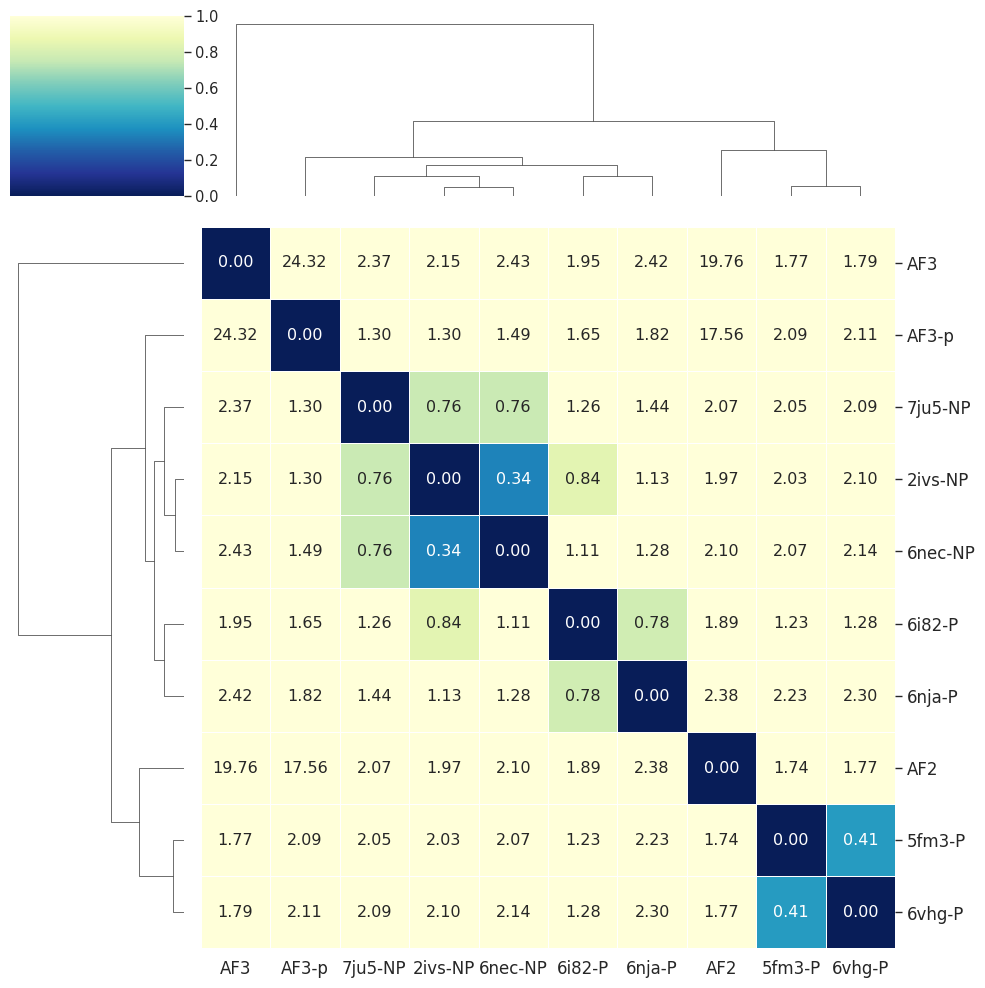

In [8]:
matrices = extract_labels_and_create_matrix_for_protein(rmsd_dict)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
for protein, matrix in matrices.items():
    print(f"Plotting clustermap for {protein}")
    
   
    plot_clustermap_with_condensed(protein,matrix,'globalRMSD') #dendrogram_ratio=(0, 0)

### Cluster based on segment RMSD

Plotting clustermap for P07949


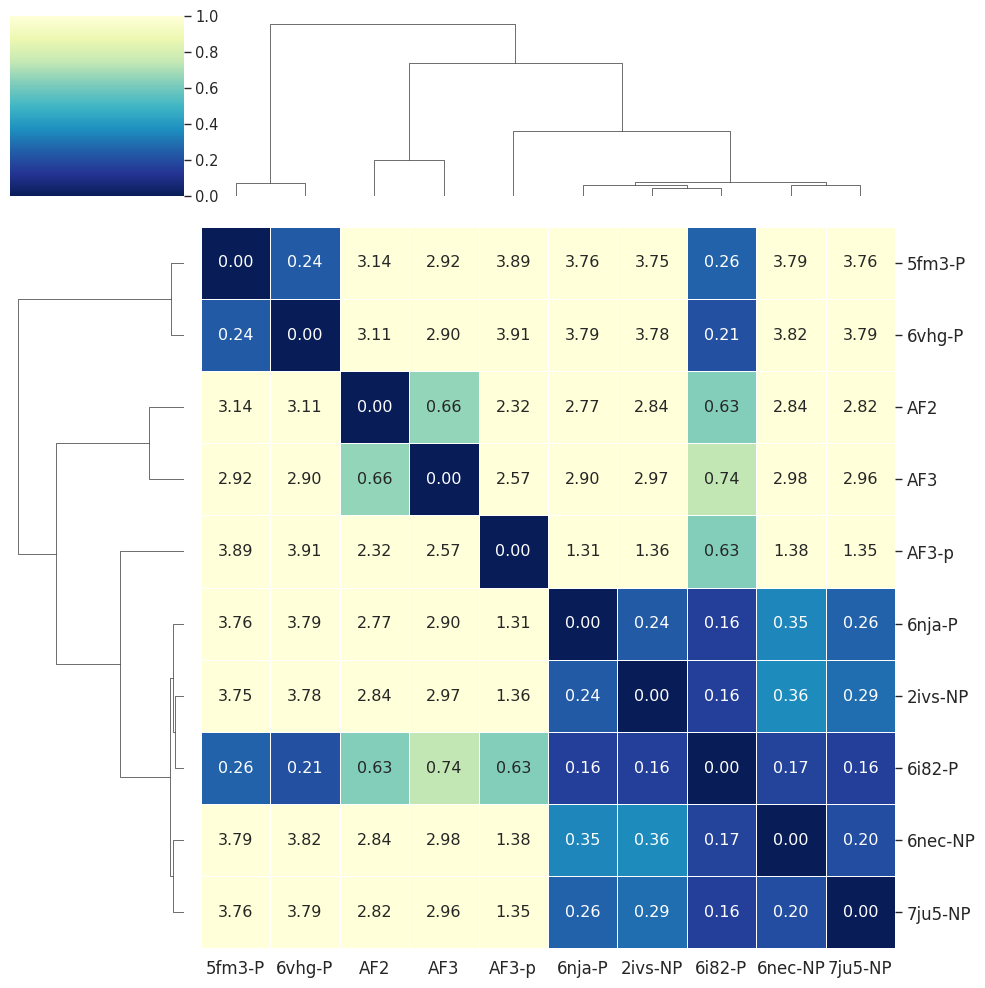

In [18]:
matrices = extract_labels_and_create_matrix_for_protein(rmsd_dict)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
for protein, matrix in matrices.items():
    print(f"Plotting clustermap for {protein}")
    
   
    plot_clustermap_with_condensed(protein,matrix,'segmentRMSD') #dendrogram_ratio=(0, 0)

## Contact Map analysis

In [19]:
lookup_dict={}

p_np_labels=pd.read_csv(os.path.join('PDB_phospho_data','pdbDF_newP_NP.txt'),sep='\t')
for idx, row in p_np_labels.iterrows():
    lookup_dict[f'{row["PDBID"]}__{row["CHAINID"]}']=f"{row['PDBID']}-{row['P_status']}"

af3_names=pd.read_csv('AF3_filenames_filt.txt',sep='\t')
af3_names['af3_fullname']=af3_names['AF3name'].str.replace('-', '_') + '__A'
af3namelist=list(set(af3_names['af3_fullname'].tolist()))
# print (af3namelist)

for afname in af3namelist:
    if 'AF3__A' in afname:
        lookup_dict[afname]='AF3'
    else:
        lookup_dict[afname]='AF3-p'
        
protlist=list(set(af3_names.ACC_ID.tolist()))

for protname in protlist:
    lookup_dict[f'AF-{protname}-F1-model_v4__A']='AF2'


#### PDB file pointers to calculate residue contacts 

In [20]:
## prepare file as input for contact map

protid='P07949' ## change protein id here
rmsd_df = pd.read_csv("RMSD_Foldintact_clustering_infile.txt", sep='\t')
rmsd_df=rmsd_df.loc[rmsd_df.ACC_ID==protid]


# Initialize a set to store unique entries
prot_set = set()

def get_pdbfile(prot):
    """Determine pdbfile path based on whether the entry is an AF model or PDB."""
    if 'AF3' in prot or 'F1-model_v4' in prot:
        return f'PDB_Files/{prot.split("__")[0]}_{prot.split("__")[1]}.pdb'
    else:
        pdbid, chainid = prot.split('__')
        return f'PDB_Files/{pdbid}_{chainid}.pdb'

# Iterate over each row in the DataFrame and create the list
for _, row in rmsd_df.iterrows():
    # Process prot1
    pdbid1, chainid1 = row['prot1'].split('__')
    pdbname1=lookup_dict.get(row['prot1'])
    pdbfile1 = get_pdbfile(row['prot1'])
    pdbpos1 = row['PDBPOS_1']
    prot_set.add((pdbname1, chainid1, pdbfile1, pdbpos1))
    
    # Process prot2
    pdbid2, chainid2 = row['prot2'].split('__')
    pdbname2=lookup_dict.get(row['prot2'])
    pdbfile2 = get_pdbfile(row['prot2'])
    pdbpos2 = row['PDBPOS_2']
    prot_set.add((pdbname2, chainid2, pdbfile2, pdbpos2))

# Convert set to a list (to keep unique entries)
pdb_data_list = list(prot_set)

pdb_data_list


[('2ivs-NP', 'A', 'PDB_Files/2ivs_A.pdb', '905,928'),
 ('6i82-P', 'A', 'PDB_Files/6i82_A.pdb', 'nan,928.0'),
 ('AF3', 'A', 'PDB_Files/P07949_AF3_A.pdb', '905,928'),
 ('7ju5-NP', 'B', 'PDB_Files/7ju5_B.pdb', '905.0,928.0'),
 ('6vhg-P', 'A', 'PDB_Files/6vhg_A.pdb', '905,928'),
 ('5fm3-P', 'A', 'PDB_Files/5fm3_A.pdb', '905,928'),
 ('AF3-p', 'A', 'PDB_Files/P07949_AF3_905_928_A.pdb', '905,928'),
 ('6vhg-P', 'A', 'PDB_Files/6vhg_A.pdb', '905.0,928.0'),
 ('AF2', 'A', 'PDB_Files/AF-P07949-F1-model_v4_A.pdb', '905,928'),
 ('6nec-NP', 'A', 'PDB_Files/6nec_A.pdb', '905,928'),
 ('6nja-P', 'A', 'PDB_Files/6nja_A.pdb', '905,928'),
 ('7ju5-NP', 'B', 'PDB_Files/7ju5_B.pdb', '905,928'),
 ('6nja-P', 'A', 'PDB_Files/6nja_A.pdb', '905.0,928.0'),
 ('6i82-P', 'A', 'PDB_Files/6i82_A.pdb', '905,928')]

### Get residue contacts based on CA/CB atoms 

In [43]:
import os
from Bio import PDB
from collections import defaultdict

def load_structure(struct_file):
    """Load PDB or MMCIF structure from a file."""
    if struct_file.endswith('.pdb'):
        parser = PDB.PDBParser(QUIET=True)
    else:
        parser = PDB.MMCIFParser(QUIET=True)
    structure = parser.get_structure('structure', struct_file)
    return structure

def get_resname_from_pdb(structure, chain_id, pdb_pos):
    """Get residue name from PDB file based on PDBPOS, either from ATOM or HETATM."""
    chain = structure[0][chain_id]
    
    # Try to find in ATOM section
    try:
        residue = chain[int(pdb_pos)]
        resname = residue.get_resname()
        return resname
    except KeyError:
        pass

    # If not found in ATOM, check HETATM section for phospho-sites
    hetatm_residues = [('H_TPO', int(pdb_pos), ' '),  # Phospho-Thr
                       ('H_SEP', int(pdb_pos), ' '),  # Phospho-Ser
                       ('H_PTR', int(pdb_pos), ' ')]  # Phospho-Tyr

    for het_residue_id in hetatm_residues:
        try:
            residue = chain[het_residue_id]
            resname = residue.get_resname()
            return resname
        except KeyError:
            pass

    return None

def get_residue_contacts(structure, chain_id, pdb_pos, radius=8.0):
    """Get residues within a given radius of a specific residue."""
    chain = structure[0][chain_id]
    contacts = set()

    # Get the resname and residue object
    resname = get_resname_from_pdb(structure, chain_id, pdb_pos)
    if not resname:
        print(f"Residue {pdb_pos} not found.")
        return contacts

    try:
        residue = chain[int(pdb_pos)]  # For ATOM section
    except KeyError:
        # Try in HETATM if it's a phospho-residue
        residue = None
        hetatm_residues = [('H_TPO', int(pdb_pos), ' '), ('H_SEP', int(pdb_pos), ' '), ('H_PTR', int(pdb_pos), ' ')]
        for het_residue_id in hetatm_residues:
            try:
                residue = chain[het_residue_id]
                break
            except KeyError:
                pass

    if residue is None:
        print(f"Residue {pdb_pos} not found in ATOM or HETATM.")
        return contacts

    # Get neighbors within the radius
    for other_residue in chain.get_residues():
        if other_residue != residue:
            try:
                dist = residue['CA'] - other_residue['CA']
                if dist <= radius:
                    contacts.add(other_residue.id[1])  # Add residue ID to contacts
            except KeyError:
                pass

    return contacts

def get_combined_contacts(pdb_file, chain_id, pdb_positions, radius=8.0):
    """Combine contacts from multiple residues within a given radius."""
    structure = load_structure(pdb_file)
    all_contacts = set()

    for pdb_pos in pdb_positions.split(','):
        if pdb_pos.lower() != 'nan' and pdb_pos != '' and not pd.isna(pdb_pos):
            pdb_pos=int(float(pdb_pos))
#         print (pdb_pos)
            contacts = get_residue_contacts(structure, chain_id, pdb_pos, radius)
    #         print (contacts)
            all_contacts.update(contacts)

    return list(all_contacts)

def generate_contact_map(pdb_data):
    """
    Generate contact maps for a list of PDB structures with PDBID, chain, and residue positions.
    The output is a dictionary with the PDBID as key and contact residues as values.
    """
    contact_map = defaultdict(list)
    for pdbid, chain_id, pdb_file, pdb_positions in pdb_data:
#         print(f"Processing {pdbid}, chain {chain_id}, positions {pdb_positions}")
        contacts = get_combined_contacts(pdb_file, chain_id, pdb_positions)
        contact_map[pdbid] = contacts

    return contact_map


contact_map = generate_contact_map(pdb_data_list)



### Calculate Jaccard similarity and perform hierarchical cluster

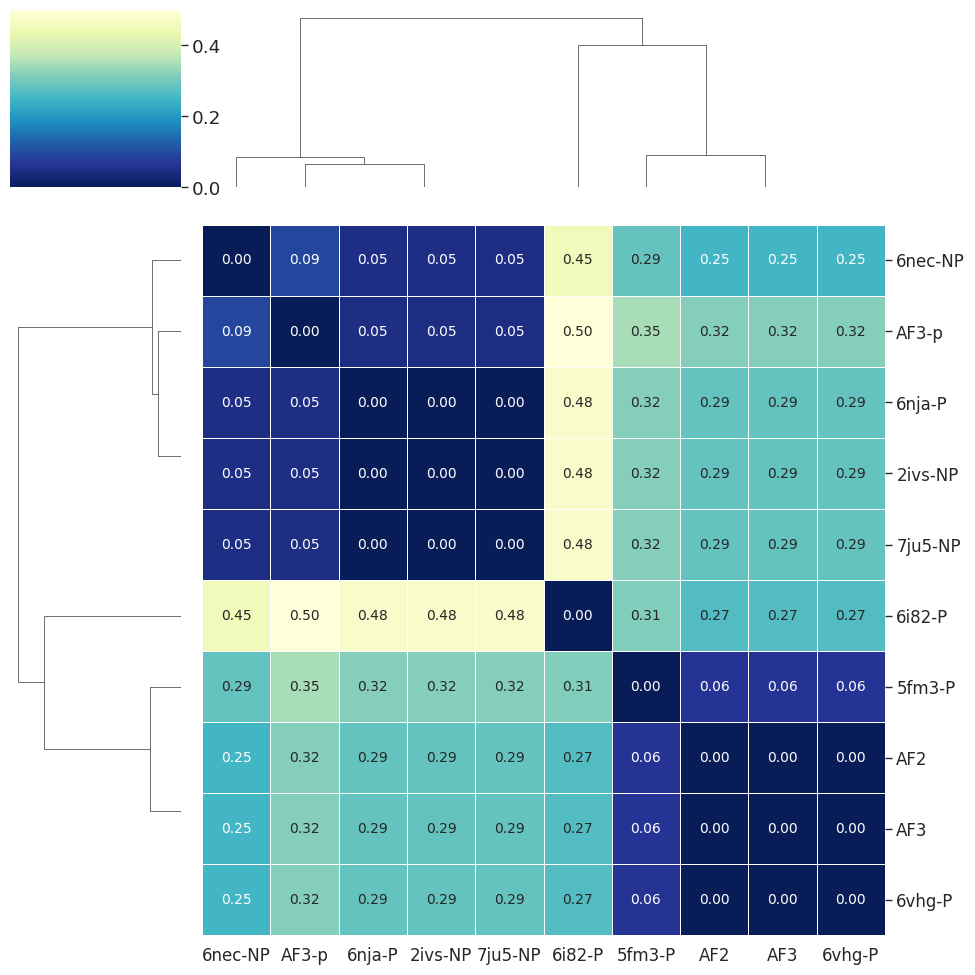

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
sns.set_context('paper',font_scale=1.5)

def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets."""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union

def compute_jaccard_matrix(contact_map):
    """Compute the Jaccard similarity matrix from a contact map dictionary."""
    pdb_keys = list(contact_map.keys())
    num_structures = len(pdb_keys)
    
    # Initialize an empty similarity matrix
    jaccard_matrix = np.zeros((num_structures, num_structures))
    
    # Loop over all pairs of structures to compute Jaccard similarity
    for i in range(num_structures):
        for j in range(num_structures):
            if i == j:
                jaccard_matrix[i][j] = 1.0  # Similarity with itself is 1
            else:
                set1 = set(contact_map[pdb_keys[i]])
                set2 = set(contact_map[pdb_keys[j]])
                jaccard_matrix[i][j] = jaccard_similarity(set1, set2)
    
    # Convert to DataFrame for easier handling
    jaccard_df = pd.DataFrame(jaccard_matrix, index=pdb_keys, columns=pdb_keys)
    return jaccard_df

def jaccard_to_distance(jaccard_df):
    """Convert Jaccard similarity matrix to a distance matrix."""
    jaccard_distance = 1 - jaccard_df
    return jaccard_distance

def hierarchical_clustering(jaccard_distance_df):
    """Perform hierarchical clustering and plot a heatmap with dendrogram."""
    # Convert the square distance matrix to condensed form
    condensed_distance_matrix = squareform(jaccard_distance_df.values)

    # Compute the linkage matrix
    linkage_matrix = linkage(condensed_distance_matrix, method='average')

    # Plot the heatmap with dendrogram
    cluster_map=sns.clustermap(jaccard_distance_df, row_linkage=linkage_matrix, col_linkage=linkage_matrix,
                   cmap='YlGnBu_r', annot=True, fmt=".2f", linewidths=0.5,annot_kws={"fontsize": 10})
    
    # Rotate the x and y axis labels and adjust font size
    cluster_map.ax_heatmap.set_xticklabels(
        cluster_map.ax_heatmap.get_xticklabels(), 
        rotation=0,  # Rotate labels by 45 degrees
        fontsize=12   # Set font size
    )
    cluster_map.ax_heatmap.set_yticklabels(
        cluster_map.ax_heatmap.get_yticklabels(), 
        rotation=0,   # Keep labels horizontal
        fontsize=12   # Set font size
    )
    
    plt.tight_layout()
    plt.savefig(f'{protid}_contactMap.svg', format='svg', dpi=1200)


    plt.show()


#  Compute Jaccard similarity matrix
jaccard_df = compute_jaccard_matrix(contact_map)

# Convert to Jaccard distance matrix
jaccard_distance_df = jaccard_to_distance(jaccard_df)

# Perform hierarchical clustering and plot heatmap
hierarchical_clustering(jaccard_distance_df)


## RIN analysis with co evolutionary mapping (EVcoupling and RIN data)



### Edge betweeness analysis + co-evolutionary signals

In [25]:
import networkx as nx
from sklearn.metrics import jaccard_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Extract residue contacts from a PDB
def extract_residue_contacts(pdb_file, chain_id, cutoff=8.0):
    """
    Extract residue-residue contacts from a PDB file, optionally including phosphorylated residues.

    Parameters:
    pdb_file (str): Path to the PDB file.
    chain_id (str): Chain ID to analyze.
    cutoff (float): Distance cutoff for residue contacts in Å.

    Returns:
    nx.Graph: Residue Interaction Network (RIN).
    """
    u = mda.Universe(pdb_file)
    chain = u.select_atoms(f"segid {chain_id} and (protein or resname PTR SEP TPO)")
    
    G = nx.Graph()
    for res1 in chain.residues:
        for res2 in chain.residues:
            if res1 != res2:
                dist = distance_array(res1.atoms.positions, res2.atoms.positions).min()
                if dist <= cutoff:
                    G.add_edge(res1.resid, res2.resid)
    return G

def filter_valid_triples(entries):
    """
    Generate triples where exactly one entry is an AF model and the other two are PDB entries.

    Parameters:
    entries (list): List of entries (e.g., ['6ade_A', '4wnc_A', 'P04406_AF3_51_151_A']).

    Returns:
    list: Filtered list of valid triples.
    """
    # Generate all possible triples
    all_triples = list(combinations(entries, 3))

    # Filter triples: exactly one AF model
    valid_triples = [
        triple for triple in all_triples
        if sum(('AF-' in entry or 'AF3' in entry or 'F1-model_v4' in entry) for entry in triple) == 1
    ]

    return valid_triples

def filter_valid_triples_pdb(entries):
    """
    Generate triples where exactly one entry is an AF model and the other two are PDB entries.

    Parameters:
    entries (list): List of entries (e.g., ['6ade_A', '4wnc_A', 'P04406_AF3_51_151_A']).

    Returns:
    list: Filtered list of valid triples.
    """
    # Generate all possible triples
    all_triples = list(combinations(entries, 3))

    

    return all_triples

# Utility function: Calculate Jaccard similarity for individual residue contacts
def calculate_residue_contact_similarity(G1, G2, residue):
    """
    Calculate Jaccard similarity for residue contact networks between G1 and G2.
    Residue is the specific residue being analyzed.
    """
    # Get the neighbors for the residue
    neighbors_G1 = set(G1.neighbors(residue))
    neighbors_G2 = set(G2.neighbors(residue))

    # Calculate Jaccard similarity for the residue's contact networks
    common_neighbors = len(neighbors_G1 & neighbors_G2)
    total_neighbors = len(neighbors_G1 | neighbors_G2)
    
    jaccard_sim = common_neighbors / total_neighbors if total_neighbors != 0 else 0
    return jaccard_sim

# Utility function: Calculate Co-evolutionary similarity for residue contacts
def calculate_residue_coevolution_similarity(coevol_dict, G1, G2, residue):
    """
    Compare co-evolving pairs for a specific residue between G1 and G2 based on co-evolutionary edge probabilities.
    Returns Jaccard similarity for co-evolving edges of the residue.
    """
    common_coevol = 0
    total_coevol = 0
    
    for (res1, res2), prob in coevol_dict.items():
        # Check if (res1, res2) or (res2, res1) exists as an edge in both G1 and G2
        if (res1 == residue or res2 == residue):  # Focus on edges involving the residue
            if (G1.has_edge(res1, res2) or G1.has_edge(res2, res1)) and (G2.has_edge(res1, res2) or G2.has_edge(res2, res1)):
                common_coevol += 1
            total_coevol += 1
    
    jaccard_sim = common_coevol / total_coevol if total_coevol != 0 else 0
    return jaccard_sim

# Extract subgraph for specific residues
def extract_residue_contacts_subgraph(G, residues):
    """Extract the subgraph containing residue contacts for specific residues and their neighbors."""
    nodes_to_include = set(residues)
    for residue in residues:
#         print ("Residue: ", residue,'\n')
        if residue in G.nodes:
            neighbors = list(G.neighbors(residue))
#             print ("Neighbors:",neighbors,'\n')
            nodes_to_include.update(neighbors)
    return G.subgraph(nodes_to_include)


# Main function to perform analysis
def analyze_AF_vs_PDB_individual_residue(G1, G2, G3, coevol_dict, residues, af_label, pdb1_label, pdb2_label):
    """
    Analyze residue contact networks and co-evolutionary similarities between AF and PDB structures.
    Calculate similarity for each residue individually.
    
    Parameters:
    - G1: AF graph (nx.Graph)
    - G2: PDB1 graph (nx.Graph)
    - G3: PDB2 graph (nx.Graph)
    - coevol_dict: Dictionary of co-evolutionary pairs with edge probabilities {(res1, res2): prob}
    - residues: List of residues to analyze.
    
    Returns:
    A dictionary containing the average similarity scores.
    """
    contact_sim_AF_PDB1 = []
    contact_sim_AF_PDB2 = []
    coevol_sim_AF_PDB1 = []
    coevol_sim_AF_PDB2 = []

    # For each residue, calculate contact and co-evolutionary similarities
    for residue in residues:
        # Calculate contact similarity for the residue
        contact_sim1 = calculate_residue_contact_similarity(G1, G2, residue)
        contact_sim2 = calculate_residue_contact_similarity(G1, G3, residue)
        
        # Calculate co-evolutionary similarity for the residue
        coevol_sim1 = calculate_residue_coevolution_similarity(coevol_dict, G1, G2, residue)
        coevol_sim2 = calculate_residue_coevolution_similarity(coevol_dict, G1, G3, residue)

        contact_sim_AF_PDB1.append(contact_sim1)
        contact_sim_AF_PDB2.append(contact_sim2)
        coevol_sim_AF_PDB1.append(coevol_sim1)
        coevol_sim_AF_PDB2.append(coevol_sim2)
    
    # Aggregate results by calculating the mean similarity for all residues
    result = {
    f"Contact {af_label} vs {pdb1_label}": np.mean(contact_sim_AF_PDB1),
    f"Co-evol {af_label} vs {pdb1_label}": np.mean(coevol_sim_AF_PDB1),
    f"Contact {af_label} vs {pdb2_label}": np.mean(contact_sim_AF_PDB2),
    f"Co-evol {af_label} vs {pdb2_label}": np.mean(coevol_sim_AF_PDB2),
    }

    
    return result

def order_triple(triple):
    """
    Ensure the AF model is the first element in the triple, followed by PDB entries.

    Parameters:
    triple (tuple): A triple containing one AF model and two PDB structures.

    Returns:
    tuple: Ordered triple with the AF model first.
    """
    af_entry = [entry for entry in triple if 'AF-' in entry or 'AF3' in entry or 'F1-model_v4' in entry]
    pdb_entries = [entry for entry in triple if entry not in af_entry]
    return tuple(af_entry + pdb_entries)


# Utility function: Calculate Jaccard similarity for contact networks
def calculate_contact_similarity(G1, G2):
    # Extract edges from both graphs (contact networks)
    edges_G1 = set(G1.edges())
    edges_G2 = set(G2.edges())
    
    # Calculate Jaccard similarity
    common_edges = len(edges_G1 & edges_G2)
    total_edges = len(edges_G1 | edges_G2)
    
    # Jaccard similarity
    jaccard_sim = common_edges / total_edges if total_edges != 0 else 0
    return jaccard_sim



def calculate_coevolution_similarity(coevol_dict, G1, G2):
    """
    Compare co-evolving pairs in G1 and G2 based on co-evolutionary edge probabilities.
    Returns Jaccard similarity for the co-evolving edges.
    """
    common_coevol = 0
    total_coevol = 0
    
    for (res1, res2), prob in coevol_dict.items():
        # Check if (res1, res2) or (res2, res1) exists as an edge in both G1 and G2
        if (G1.has_edge(res1, res2) or G1.has_edge(res2, res1)) and (G2.has_edge(res1, res2) or G2.has_edge(res2, res1)):
            common_coevol += 1
        total_coevol += 1
    
    # Jaccard similarity for co-evolving pairs
    jaccard_sim = common_coevol / total_coevol if total_coevol != 0 else 0
    return jaccard_sim


# Main function to perform analysis
def analyze_AF_vs_PDB(G1, G2, G3, coevol_dict, af_label, pdb1_label, pdb2_label):
    """
    Analyze the residue contact networks and co-evolutionary similarities between AF and PDB structures.
    Parameters:
    - G1: AF graph (nx.Graph)
    - G2: PDB1 graph (nx.Graph)
    - G3: PDB2 graph (nx.Graph)
    - coevol_dict: Dictionary of co-evolutionary pairs with edge probabilities { (res1, res2): prob }
    
    Returns:
    A dictionary containing the similarity scores.
    """
    
    # Calculate contact similarity between AF and PDB1
    contact_sim_AF_PDB1 = calculate_contact_similarity(G1, G2)
    
    # Calculate contact similarity between AF and PDB2
    contact_sim_AF_PDB2 = calculate_contact_similarity(G1, G3)
    
    # Calculate co-evolutionary similarity between AF and PDB1
    coevol_sim_AF_PDB1 = calculate_coevolution_similarity(coevol_dict, G1, G2)
    
    # Calculate co-evolutionary similarity between AF and PDB2
    coevol_sim_AF_PDB2 = calculate_coevolution_similarity(coevol_dict, G1, G3)
    
    # Return a summary of results
    result = {
    f"Contact {af_label} vs {pdb1_label}": contact_sim_AF_PDB1,
    f"Co-evol {af_label} vs {pdb1_label}": coevol_sim_AF_PDB1,
    f"Contact {af_label} vs {pdb2_label}": contact_sim_AF_PDB2,
    f"Co-evol {af_label} vs {pdb2_label}": coevol_sim_AF_PDB2,
    }

    
    return result



def analyze_contacts_coevol(protid, entries, pdb_mapping,coevoldf, phosphosites, nonphosphosites):
    """Analyze residue interaction networks for a given list of PDB entries."""
#     global_results,subgraph_reuslts = [],[]

    # Fixed labels for x-axis categories
    comparison_types = ["Contact All", "Co-evol All", "Contact Subgraph", "Co-evol Subgraph"]
    model_types = ["AF3-p", "AF2", "AF3"]  # Order for grouping
    # Store results dynamically for each AF-PDB pair
    grouped_data = {label: {model: {} for model in model_types} for label in comparison_types}

    # Generate and filter valid triples
    all_triples = filter_valid_triples(entries)
    ordered_triples = [order_triple(triple) for triple in all_triples]  # Ensure AF comes first

    for af_entry, pdb1_entry, pdb2_entry in ordered_triples:
        if 'AF3_A' in af_entry:
            af_label='AF3'
        elif 'AF-' in af_entry:
            af_label='AF2'
        else:
            af_label='AF3-p'
        print(f"Analyzing triple: AF={af_label}, PDB1={pdb1_entry}, PDB2={pdb2_entry}\n")

        # Get PDB file paths and chain IDs
        af_pdb, chain_af = get_pdbfile_rin(af_entry)
        pdb1_file, chain1 = get_pdbfile_rin(pdb1_entry)
        pdb2_file, chain2 = get_pdbfile_rin(pdb2_entry)

        # Build RINs
        G_af = extract_residue_contacts(af_pdb, chain_af)
        G_pdb1 = extract_residue_contacts(pdb1_file, chain1)
        G_pdb2 = extract_residue_contacts(pdb2_file, chain2)

        # Extract subgraphs
        G_af_sub = extract_residue_contacts_subgraph(G_af, phosphosites)
        G_pdb1_sub = extract_residue_contacts_subgraph(G_pdb1, nonphosphosites)
        G_pdb2_sub = extract_residue_contacts_subgraph(G_pdb2, nonphosphosites)
#         print ("PDB1-edges\n")
#         print (set(G_pdb1_sub.edges()),'\n')
#         print ("PDB2-edges\n")
#         print (set(G_pdb2_sub.edges()),'\n')

        
        edge_probabilities = coev_score(coevoldf, phosphosites)
        
        contact_results_global = analyze_AF_vs_PDB(G_af, G_pdb1, G_pdb2, edge_probabilities, \
                                                   af_label, pdb1_entry, pdb2_entry)

        contact_results_subgraph = analyze_AF_vs_PDB_individual_residue(G_af_sub, G_pdb1_sub, \
                                                                        G_pdb2_sub, edge_probabilities, \
                                                                        phosphosites, af_label, pdb1_entry, pdb2_entry)

        
        print ("*************** RESIDUE CONTACTS ALL*****************\n")

        for key, val in contact_results_global.items():
            print (f"{key}: {val}")
    
        print ("\n*************** RESIDUE CONTACTS SUBGRAPH *****************\n")
        for key, val in contact_results_subgraph.items():
            print (f"{key}: {val}")
        
        # Extract labels and values
        # Extract labels and values
        labelsG = list(contact_results_global.keys())  # Now contains "AF vs PDB1" instead of generic labels
        valuesG = list(contact_results_global.values())

        labelsS = list(contact_results_subgraph.keys())
        valuesS = list(contact_results_subgraph.values())

        # Store values in a grouped format with proper separation of Contact & Co-evolution
        for key in comparison_types:
            if key == "Contact All":
                grouped_data[key][af_label][f"{af_label} vs {pdb1_entry}"] = contact_results_global.get(f"Contact {af_label} vs {pdb1_entry}", 0)
                grouped_data[key][af_label][f"{af_label} vs {pdb2_entry}"] = contact_results_global.get(f"Contact {af_label} vs {pdb2_entry}", 0)

            elif key == "Co-evol All":
                grouped_data[key][af_label][f"{af_label} vs {pdb1_entry}"] = contact_results_global.get(f"Co-evol {af_label} vs {pdb1_entry}", 0)
                grouped_data[key][af_label][f"{af_label} vs {pdb2_entry}"] = contact_results_global.get(f"Co-evol {af_label} vs {pdb2_entry}", 0)

            elif key == "Contact Subgraph":
                grouped_data[key][af_label][f"{af_label} vs {pdb1_entry}"] = contact_results_subgraph.get(f"Contact {af_label} vs {pdb1_entry}", 0)
                grouped_data[key][af_label][f"{af_label} vs {pdb2_entry}"] = contact_results_subgraph.get(f"Contact {af_label} vs {pdb2_entry}", 0)

            elif key == "Co-evol Subgraph":
                grouped_data[key][af_label][f"{af_label} vs {pdb1_entry}"] = contact_results_subgraph.get(f"Co-evol {af_label} vs {pdb1_entry}", 0)
                grouped_data[key][af_label][f"{af_label} vs {pdb2_entry}"] = contact_results_subgraph.get(f"Co-evol {af_label} vs {pdb2_entry}", 0)




    # Convert `grouped_data` into a DataFrame, filtering out non-PDB comparisons
    heatmap_data = []
    for comp_type in comparison_types:
        for model in model_types:
            for pdb in entries[:3]:  # Handle 2 or 3 PDBs
                label_pdb = f"{model} vs {pdb}"

                # **Only include valid "AF vs PDB" comparisons**
                if label_pdb in grouped_data[comp_type][model]:
                    score = grouped_data[comp_type][model][label_pdb]
                    heatmap_data.append([comp_type, model, pdb, score])

    # Create a DataFrame from filtered data
    df = pd.DataFrame(heatmap_data, columns=["Comparison Type", "Model", "PDB", "Score"])
    df["Comparison Type"] = pd.Categorical(df["Comparison Type"], categories=comparison_types, ordered=True)
  

    # Replace values in the "PDB" column
    df["PDB"] = df["PDB"].replace(pdb_mapping)


    df = df.sort_values("Comparison Type")
    df.to_csv(f"{protid}_coevol.txt",sep='\t',index=False)

    # Convert into pivot table for heatmap
    pivot_table = df.pivot_table(index=["Model", "PDB"], columns="Comparison Type", values="Score")

    # **Plot heatmap**
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Similarity Score'})

    plt.title("Heatmap - AF Models vs PDB Similarity Scores", fontsize=16)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()


        
def analyze_contacts_coevol_pdball(entries, coevoldf, phosphosites, nonphosphosites):
    """Analyze residue interaction networks for a given list of PDB entries."""
#     global_results,subgraph_reuslts = [],[]



    # Generate and filter valid triples
    all_triples = filter_valid_triples_pdb(entries)
    ordered_triples = [order_triple(triple) for triple in all_triples]  # Ensure AF comes first

    for pdb1_entry, pdb2_entry, pdb3_entry in ordered_triples:
        
        print(f"Analyzing triple: PDB1={pdb1_entry}, PDB2={pdb2_entry}, PDB3={pdb3_entry}\n")

        # Get PDB file paths and chain IDs
        pdb1_file, chain1 = get_pdbfile_rin(pdb1_entry)
        pdb2_file, chain2 = get_pdbfile_rin(pdb2_entry)
        pdb3_file, chain3 = get_pdbfile_rin(pdb3_entry)

        # Build RINs
        G_af = extract_residue_contacts(pdb1_file, chain1)
        G_pdb1 = extract_residue_contacts(pdb2_file, chain2)
        G_pdb2 = extract_residue_contacts(pdb3_file, chain3)

        # Extract subgraphs
        G_af_sub = extract_residue_contacts_subgraph(G_af, phosphosites)
        G_pdb1_sub = extract_residue_contacts_subgraph(G_pdb1, nonphosphosites)
        G_pdb2_sub = extract_residue_contacts_subgraph(G_pdb2, nonphosphosites)
#         print ("PDB1-edges\n")
#         print (set(G_pdb1_sub.edges()),'\n')
#         print ("PDB2-edges\n")
#         print (set(G_pdb2_sub.edges()),'\n')

        
        edge_probabilities = coev_score(coevoldf, phosphosites)
        
        contact_results_global = analyze_AF_vs_PDB(G_af, G_pdb1, G_pdb2, edge_probabilities, \
                                                   pdb1_entry, pdb2_entry,pdb3_entry)

        contact_results_subgraph = analyze_AF_vs_PDB_individual_residue(G_af_sub, G_pdb1_sub, \
                                                                        G_pdb2_sub, edge_probabilities, \
                                                                        phosphosites, pdb1_entry, pdb2_entry,pdb3_entry)

        
        print ("*************** RESIDUE CONTACTS ALL*****************\n")

        for key, val in contact_results_global.items():
            print (f"{key}: {val}")
    
        print ("\n*************** RESIDUE CONTACTS SUBGRAPH *****************\n")
        for key, val in contact_results_subgraph.items():
            print (f"{key}: {val}")
        
        # Extract labels and values
        # Extract labels and values
        labelsG = list(contact_results_global.keys())  # Now contains "AF vs PDB1" instead of generic labels
        valuesG = list(contact_results_global.values())

        labelsS = list(contact_results_subgraph.keys())
        valuesS = list(contact_results_subgraph.values())

        


        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size

        # First subplot (Global results)
        axes[0].bar(labelsG, valuesG, color=['red', 'steelblue','indianred', 'skyblue'])
        axes[0].set_xticklabels(labelsG, rotation=20, ha="right")
        axes[0].set_ylabel("Similarity Score")
        axes[0].set_title("AF vs PDB Contact and Co-evolution Similarities (Global)")
        axes[0].set_ylim(0, 1)

        # Second subplot (Subgraph results)
        axes[1].bar(labelsS, valuesS, color=['red', 'steelblue', 'indianred',  'skyblue'])
        axes[1].set_xticklabels(labelsS, rotation=20, ha="right")
        axes[1].set_ylabel("Similarity Score")
        axes[1].set_title("AF vs PDB Contact and Co-evolution Similarities (Subgraphs)")
        axes[1].set_ylim(0, 1)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show plot
        plt.show()

        
#         global_results.append(contact_results_global)
#         subgraph_results.append(contact_results_subgraph)
   
#     return (global_results,subgraph_results)


## P04406

Analyzing triple: AF=AF3-p, PDB1=6ade_A, PDB2=1u8f_O



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 6ade_A: 0.8430004361098997
Co-evol AF3-p vs 6ade_A: 0.8210290827740492
Contact AF3-p vs 1u8f_O: 0.8905795479973149
Co-evol AF3-p vs 1u8f_O: 0.825503355704698

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 6ade_A: 0.8043184885290149
Co-evol AF3-p vs 6ade_A: 0.6875
Contact AF3-p vs 1u8f_O: 0.8439542483660131
Co-evol AF3-p vs 1u8f_O: 0.5208333333333333
Analyzing triple: AF=AF2, PDB1=6ade_A, PDB2=1u8f_O



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 6ade_A: 0.8266923736075407
Co-evol AF2 vs 6ade_A: 0.8238255033557047
Contact AF2 vs 1u8f_O: 0.8829246741771593
Co-evol AF2 vs 1u8f_O: 0.8271812080536913

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 6ade_A: 0.7884615384615385
Co-evol AF2 vs 6ade_A: 0.5208333333333333
Contact AF2 vs 1u8f_O: 0.967741935483871
Co-evol AF2 vs 1u8f_O: 0.5208333333333333
Analyzing triple: AF=AF3, PDB1=6ade_A, PDB2=1u8f_O



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 6ade_A: 0.8362180874080485
Co-evol AF3 vs 6ade_A: 0.8210290827740492
Contact AF3 vs 1u8f_O: 0.8958659217877095
Co-evol AF3 vs 1u8f_O: 0.825503355704698

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 6ade_A: 0.7884615384615385
Co-evol AF3 vs 6ade_A: 0.5208333333333333
Contact AF3 vs 1u8f_O: 0.967741935483871
Co-evol AF3 vs 1u8f_O: 0.5208333333333333


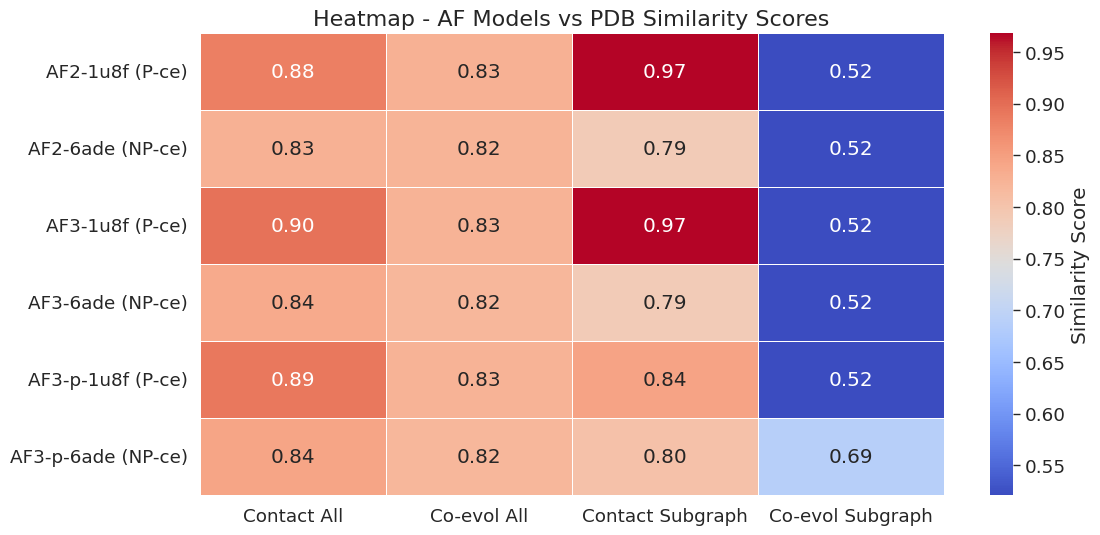

In [26]:
entries = ['6ade_A', '1u8f_O', 'P04406_AF3_51_151_A','AF-P04406-F1-model_v4_A','P04406_AF3_A']
phosphosites = [51, 151]
nonphosphosites = [51, 151]

# Define the mapping dictionary
pdb_mapping = {
    "6ade_A": "6ade (NP-ce)",
    "1u8f_O": "1u8f (P-ce)",
    # Add more mappings as needed
}

analyze_contacts_coevol("P04406",entries, pdb_mapping,'P04406_ev1_CouplingScores.csv', phosphosites, nonphosphosites)        

# P07949

Analyzing triple: AF=AF3-p, PDB1=2ivs_A, PDB2=6nja_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 2ivs_A: 0.17293967395387275
Co-evol AF3-p vs 2ivs_A: 0.8325358851674641
Contact AF3-p vs 6nja_A: 0.18280297901150983
Co-evol AF3-p vs 6nja_A: 0.8318523581681476

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 2ivs_A: 0.8076923076923077
Co-evol AF3-p vs 2ivs_A: 0.9545454545454546
Contact AF3-p vs 6nja_A: 0.8333333333333333
Co-evol AF3-p vs 6nja_A: 0.9545454545454546
Analyzing triple: AF=AF2, PDB1=2ivs_A, PDB2=6nja_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 2ivs_A: 0.2102020699852144
Co-evol AF2 vs 2ivs_A: 0.8229665071770335
Contact AF2 vs 6nja_A: 0.22034037655183755
Co-evol AF2 vs 6nja_A: 0.8202323991797676

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 2ivs_A: 0.609375
Co-evol AF2 vs 2ivs_A: 0.8136363636363637
Contact AF2 vs 6nja_A: 0.6200757575757576
Co-evol AF2 vs 6nja_A: 0.8136363636363637
Analyzing triple: AF=AF3, PDB1=2ivs_A, PDB2=6nja_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 2ivs_A: 0.20322710770471963
Co-evol AF3 vs 2ivs_A: 0.8243335611756665
Contact AF3 vs 6nja_A: 0.20655316415033728
Co-evol AF3 vs 6nja_A: 0.8222829801777171

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 2ivs_A: 0.569078947368421
Co-evol AF3 vs 2ivs_A: 0.7681818181818182
Contact AF3 vs 6nja_A: 0.580542264752791
Co-evol AF3 vs 6nja_A: 0.7681818181818182
Analyzing triple: AF=AF3-p, PDB1=2ivs_A, PDB2=6vhg_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 2ivs_A: 0.17293967395387275
Co-evol AF3-p vs 2ivs_A: 0.8325358851674641
Contact AF3-p vs 6vhg_A: 0.17899069980179905
Co-evol AF3-p vs 6vhg_A: 0.820915926179084

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 2ivs_A: 0.8076923076923077
Co-evol AF3-p vs 2ivs_A: 0.9545454545454546
Contact AF3-p vs 6vhg_A: 0.5142857142857143
Co-evol AF3-p vs 6vhg_A: 0.7227272727272727
Analyzing triple: AF=AF2, PDB1=2ivs_A, PDB2=6vhg_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 2ivs_A: 0.2102020699852144
Co-evol AF2 vs 2ivs_A: 0.8229665071770335
Contact AF2 vs 6vhg_A: 0.22427396340439817
Co-evol AF2 vs 6vhg_A: 0.8140806561859193

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 2ivs_A: 0.609375
Co-evol AF2 vs 2ivs_A: 0.8136363636363637
Contact AF2 vs 6vhg_A: 0.577485380116959
Co-evol AF2 vs 6vhg_A: 0.6727272727272727
Analyzing triple: AF=AF3, PDB1=2ivs_A, PDB2=6vhg_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 2ivs_A: 0.20322710770471963
Co-evol AF3 vs 2ivs_A: 0.8243335611756665
Contact AF3 vs 6vhg_A: 0.20823105874652267
Co-evol AF3 vs 6vhg_A: 0.8113465481886535

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 2ivs_A: 0.569078947368421
Co-evol AF3 vs 2ivs_A: 0.7681818181818182
Contact AF3 vs 6vhg_A: 0.6277777777777778
Co-evol AF3 vs 6vhg_A: 0.6727272727272727
Analyzing triple: AF=AF3-p, PDB1=6nja_A, PDB2=6vhg_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 6nja_A: 0.18280297901150983
Co-evol AF3-p vs 6nja_A: 0.8318523581681476
Contact AF3-p vs 6vhg_A: 0.17899069980179905
Co-evol AF3-p vs 6vhg_A: 0.820915926179084

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 6nja_A: 0.8333333333333333
Co-evol AF3-p vs 6nja_A: 0.9545454545454546
Contact AF3-p vs 6vhg_A: 0.5142857142857143
Co-evol AF3-p vs 6vhg_A: 0.7227272727272727
Analyzing triple: AF=AF2, PDB1=6nja_A, PDB2=6vhg_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 6nja_A: 0.22034037655183755
Co-evol AF2 vs 6nja_A: 0.8202323991797676
Contact AF2 vs 6vhg_A: 0.22427396340439817
Co-evol AF2 vs 6vhg_A: 0.8140806561859193

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 6nja_A: 0.6200757575757576
Co-evol AF2 vs 6nja_A: 0.8136363636363637
Contact AF2 vs 6vhg_A: 0.577485380116959
Co-evol AF2 vs 6vhg_A: 0.6727272727272727
Analyzing triple: AF=AF3, PDB1=6nja_A, PDB2=6vhg_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 6nja_A: 0.20655316415033728
Co-evol AF3 vs 6nja_A: 0.8222829801777171
Contact AF3 vs 6vhg_A: 0.20823105874652267
Co-evol AF3 vs 6vhg_A: 0.8113465481886535

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 6nja_A: 0.580542264752791
Co-evol AF3 vs 6nja_A: 0.7681818181818182
Contact AF3 vs 6vhg_A: 0.6277777777777778
Co-evol AF3 vs 6vhg_A: 0.6727272727272727


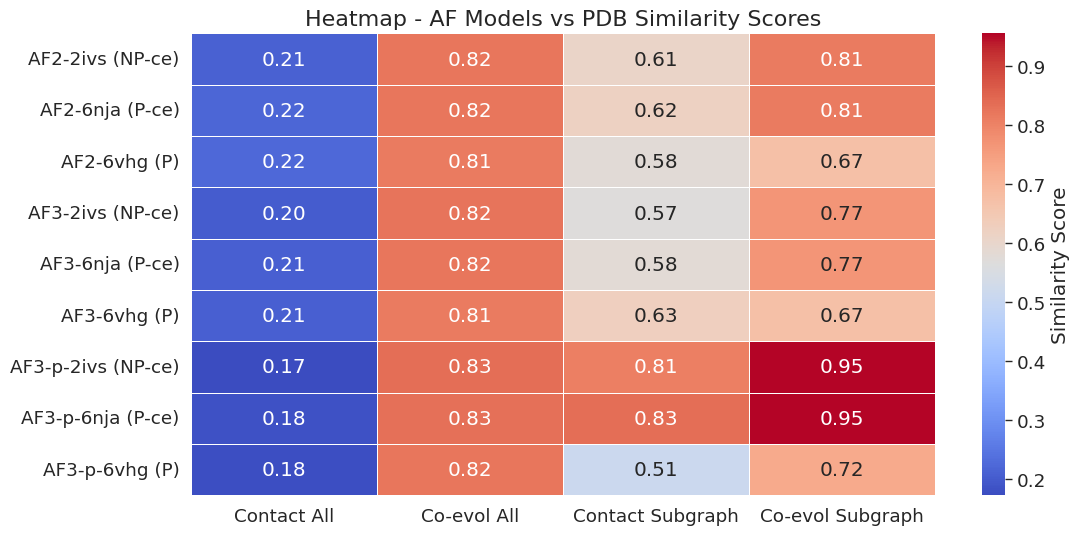

In [27]:
entries = ['2ivs_A','6nja_A', '6vhg_A', 'P07949_AF3_905_928_A','AF-P07949-F1-model_v4_A','P07949_AF3_A']
phosphosites = [905, 928]
nonphosphosites = [905, 928]
# Define the mapping dictionary
pdb_mapping = {
    "2ivs_A": "2ivs (NP-ce)",
    "6nja_A": "6nja (P-ce)",
    "6vhg_A": "6vhg (P)",
    # Add more mappings as needed
}
analyze_contacts_coevol("P07949",entries,pdb_mapping, 'P07949_ev_do m_CouplingScores.csv', phosphosites, nonphosphosites)


## P24842

Analyzing triple: AF=AF3-p, PDB1=4fmq_A, PDB2=5v62_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 4fmq_A: 0.695
Co-evol AF3-p vs 4fmq_A: 0.7653631284916201
Contact AF3-p vs 5v62_A: 0.8285529437136079
Co-evol AF3-p vs 5v62_A: 0.7877094972067039

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 4fmq_A: 0.2673509286412512
Co-evol AF3-p vs 4fmq_A: 0.44505494505494503
Contact AF3-p vs 5v62_A: 0.9619252873563219
Co-evol AF3-p vs 5v62_A: 0.7326007326007327
Analyzing triple: AF=AF2, PDB1=4fmq_A, PDB2=5v62_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 4fmq_A: 0.7438748198476426
Co-evol AF2 vs 4fmq_A: 0.7678460583488517
Contact AF2 vs 5v62_A: 0.7511882620376111
Co-evol AF2 vs 5v62_A: 0.7666045934202359

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 4fmq_A: 0.6333333333333333
Co-evol AF2 vs 4fmq_A: 0.5164835164835164
Contact AF2 vs 5v62_A: 0.2732447817836812
Co-evol AF2 vs 5v62_A: 0.46886446886446886
Analyzing triple: AF=AF3, PDB1=4fmq_A, PDB2=5v62_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 4fmq_A: 0.7159274193548387
Co-evol AF3 vs 4fmq_A: 0.7616387337057728
Contact AF3 vs 5v62_A: 0.7324516785350966
Co-evol AF3 vs 5v62_A: 0.7697082557417753

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 4fmq_A: 0.39473684210526316
Co-evol AF3 vs 4fmq_A: 0.48351648351648346
Contact AF3 vs 5v62_A: 0.3764619883040936
Co-evol AF3 vs 5v62_A: 0.554945054945055
Analyzing triple: AF=AF3-p, PDB1=4fmq_A, PDB2=7nr8_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 4fmq_A: 0.695
Co-evol AF3-p vs 4fmq_A: 0.7653631284916201
Contact AF3-p vs 7nr8_A: 0.7074006856221012
Co-evol AF3-p vs 7nr8_A: 0.7672253258845437

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 4fmq_A: 0.2673509286412512
Co-evol AF3-p vs 4fmq_A: 0.44505494505494503
Contact AF3-p vs 7nr8_A: 0.3551051051051051
Co-evol AF3-p vs 7nr8_A: 0.4926739926739927
Analyzing triple: AF=AF2, PDB1=4fmq_A, PDB2=7nr8_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 4fmq_A: 0.7438748198476426
Co-evol AF2 vs 4fmq_A: 0.7678460583488517
Contact AF2 vs 7nr8_A: 0.7077699293642785
Co-evol AF2 vs 7nr8_A: 0.7610180012414649

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 4fmq_A: 0.6333333333333333
Co-evol AF2 vs 4fmq_A: 0.5164835164835164
Contact AF2 vs 7nr8_A: 0.38888888888888884
Co-evol AF2 vs 7nr8_A: 0.46886446886446886
Analyzing triple: AF=AF3, PDB1=4fmq_A, PDB2=7nr8_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 4fmq_A: 0.7159274193548387
Co-evol AF3 vs 4fmq_A: 0.7616387337057728
Contact AF3 vs 7nr8_A: 0.846471226927253
Co-evol AF3 vs 7nr8_A: 0.7734326505276226

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 4fmq_A: 0.39473684210526316
Co-evol AF3 vs 4fmq_A: 0.48351648351648346
Contact AF3 vs 7nr8_A: 0.9312393887945671
Co-evol AF3 vs 7nr8_A: 0.5787545787545787
Analyzing triple: AF=AF3-p, PDB1=5v62_A, PDB2=7nr8_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3-p vs 5v62_A: 0.8285529437136079
Co-evol AF3-p vs 5v62_A: 0.7877094972067039
Contact AF3-p vs 7nr8_A: 0.7074006856221012
Co-evol AF3-p vs 7nr8_A: 0.7672253258845437

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3-p vs 5v62_A: 0.9619252873563219
Co-evol AF3-p vs 5v62_A: 0.7326007326007327
Contact AF3-p vs 7nr8_A: 0.3551051051051051
Co-evol AF3-p vs 7nr8_A: 0.4926739926739927
Analyzing triple: AF=AF2, PDB1=5v62_A, PDB2=7nr8_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF2 vs 5v62_A: 0.7511882620376111
Co-evol AF2 vs 5v62_A: 0.7666045934202359
Contact AF2 vs 7nr8_A: 0.7077699293642785
Co-evol AF2 vs 7nr8_A: 0.7610180012414649

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF2 vs 5v62_A: 0.2732447817836812
Co-evol AF2 vs 5v62_A: 0.46886446886446886
Contact AF2 vs 7nr8_A: 0.38888888888888884
Co-evol AF2 vs 7nr8_A: 0.46886446886446886
Analyzing triple: AF=AF3, PDB1=5v62_A, PDB2=7nr8_A



/home/pathmanaban/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


*************** RESIDUE CONTACTS ALL*****************

Contact AF3 vs 5v62_A: 0.7324516785350966
Co-evol AF3 vs 5v62_A: 0.7697082557417753
Contact AF3 vs 7nr8_A: 0.846471226927253
Co-evol AF3 vs 7nr8_A: 0.7734326505276226

*************** RESIDUE CONTACTS SUBGRAPH *****************

Contact AF3 vs 5v62_A: 0.3764619883040936
Co-evol AF3 vs 5v62_A: 0.554945054945055
Contact AF3 vs 7nr8_A: 0.9312393887945671
Co-evol AF3 vs 7nr8_A: 0.5787545787545787


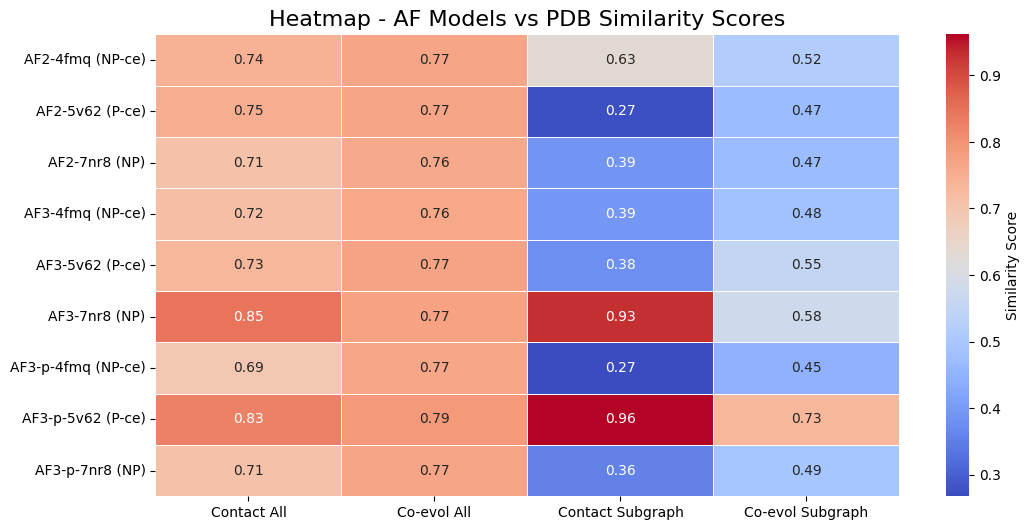

In [42]:
entries = ['4fmq_A','5v62_A', '7nr8_A', 'P28482_AF3_185_187_A','AF-P28482-F1-model_v4_A','P28482_AF3_A']
phosphosites = [185, 187]
nonphosphosites = [185, 187]
# Define the mapping dictionary
pdb_mapping = {
    "4fmq_A": "4fmq (NP-ce)",
    "5v62_A": "5v62 (P-ce)",
    "7nr8_A": "7nr8 (NP)",
    # Add more mappings as needed
}
analyze_contacts_coevol("P24842",entries, pdb_mapping ,'P28482_ev_CouplingScores.csv', phosphosites, nonphosphosites)


## Condensed combined plot

In [28]:
P04406=pd.read_csv('P04406_coevol.txt',sep='\t')
P04406['ACC_ID']='P04406'
P04406["Pstatus"] = P04406["PDB"].map({"6ade (NP-ce)": "P", "1u8f (P-ce)": "NP"})



P07949=pd.read_csv('P07949_coevol.txt',sep='\t')
P07949['ACC_ID']='P07949'
P07949=P07949.loc[P07949.PDB!='6nja (P-ce)']
P07949["Pstatus"] = P07949["PDB"].map({"2ivs (NP-ce)": "NP", "6vhg (P)": "P"})


P24842=pd.read_csv('P24842_coevol.txt',sep='\t')
P24842['ACC_ID']='P24842'
P24842=P24842.loc[P24842.PDB!='4fmq (NP-ce)']
P24842["Pstatus"] = P24842["PDB"].map({"7nr8 (NP)": "NP", "5v62 (P-ce)": "P"})




In [31]:
P04406.head()

,Comparison Type,Model,PDB,Score,ACC_ID,Pstatus
0,Contact All,AF3-p,6ade (NP-ce),0.843000,P04406,P
1,Contact All,AF3-p,1u8f (P-ce),0.890580,P04406,NP
2,Contact All,AF2,6ade (NP-ce),0.826692,P04406,P
3,Contact All,AF2,1u8f (P-ce),0.882925,P04406,NP
4,Contact All,AF3,6ade (NP-ce),0.836218,P04406,P


In [30]:
P07949.head()

,Comparison Type,Model,PDB,Score,ACC_ID,Pstatus
0,Contact All,AF3-p,2ivs (NP-ce),0.172940,P07949,NP
2,Contact All,AF3-p,6vhg (P),0.178991,P07949,P
3,Contact All,AF2,2ivs (NP-ce),0.210202,P07949,NP
5,Contact All,AF2,6vhg (P),0.224274,P07949,P
6,Contact All,AF3,2ivs (NP-ce),0.203227,P07949,NP


In [32]:
coevol_df=pd.concat([P04406,P07949,P24842])
coevol_df.head()

,Comparison Type,Model,PDB,Score,ACC_ID,Pstatus
0,Contact All,AF3-p,6ade (NP-ce),0.843000,P04406,P
1,Contact All,AF3-p,1u8f (P-ce),0.890580,P04406,NP
2,Contact All,AF2,6ade (NP-ce),0.826692,P04406,P
3,Contact All,AF2,1u8f (P-ce),0.882925,P04406,NP
4,Contact All,AF3,6ade (NP-ce),0.836218,P04406,P


In [33]:
coevol_df.loc[(coevol_df.Model=='AF2')&(coevol_df.ACC_ID=='P04406')]

,Comparison Type,Model,PDB,Score,ACC_ID,Pstatus
2,Contact All,AF2,6ade (NP-ce),0.826692,P04406,P
3,Contact All,AF2,1u8f (P-ce),0.882925,P04406,NP
7,Co-evol All,AF2,1u8f (P-ce),0.827181,P04406,NP
11,Co-evol All,AF2,6ade (NP-ce),0.823826,P04406,P
14,Contact Subgraph,AF2,6ade (NP-ce),0.788462,P04406,P
15,Contact Subgraph,AF2,1u8f (P-ce),0.967742,P04406,NP
21,Co-evol Subgraph,AF2,6ade (NP-ce),0.520833,P04406,P
22,Co-evol Subgraph,AF2,1u8f (P-ce),0.520833,P04406,NP


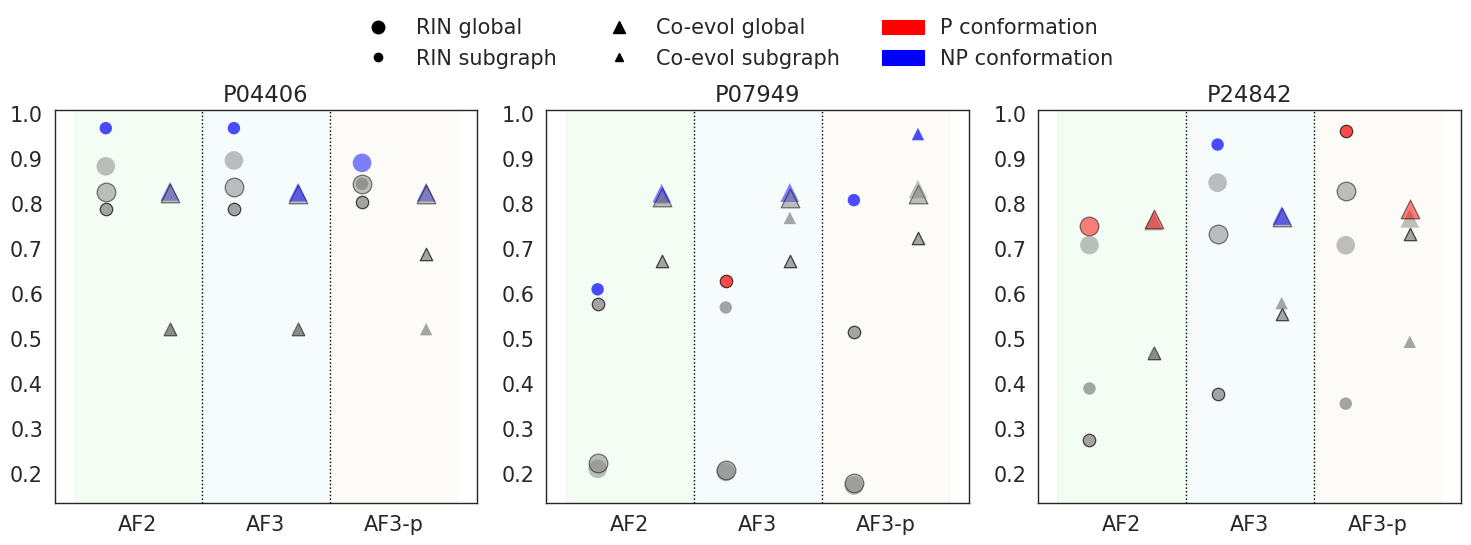

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns


sns.set_context("paper",font_scale = 1.7)


# Define models
models = ["AF2", "AF3", "AF3-p"]

# Define marker and size mappings
marker_map = {"Contact All": "o", "Contact Subgraph": "o", "Co-evol All": "^", "Co-evol Subgraph": "^"}
size_map = {"Contact All": 180, "Contact Subgraph": 80, "Co-evol All": 180, "Co-evol Subgraph": 80}

# Define a list of distinct colors for protein background shading
background_colors = ["lightgreen", "lightblue", "wheat"]

# Group and find highest score separately for Contact and Co-evol
coevol_df["is_highest"] = coevol_df.groupby(["ACC_ID", "Model", coevol_df["Comparison Type"].str.contains("Contact")])[
    "Score"].transform(lambda x: x == x.max())

# Assign colors based on highest scores within each subset
coevol_df["color"] = "grey"
coevol_df.loc[(coevol_df["Pstatus"] == "P") & (coevol_df["is_highest"]), "color"] = "red"
coevol_df.loc[(coevol_df["Pstatus"] == "NP") & (coevol_df["is_highest"]), "color"] = "blue"

# Create subplots in a single row, with one column per protein
proteins = coevol_df["ACC_ID"].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(proteins), figsize=(len(proteins) * 5, 5), sharey=True)

if len(proteins) == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one subplot

for ax, acc_id in zip(axes, proteins):
    protein_df = coevol_df[coevol_df["ACC_ID"] == acc_id]
    
    x_positions = {model: i * 2 for i, model in enumerate(models)}  # Two adjacent positions per model
    
    for i, model in enumerate(models):
        ax.axvspan(x_positions[model] - 0.5, x_positions[model] + 1.5, 
                   color=background_colors[i % len(background_colors)], alpha=0.1)
        if i < len(models) - 1:  # Add dotted line only between models, not at the last one
            ax.axvline(x_positions[model] + 1.5, color='black', linestyle='dotted', linewidth=1)
    
    for comp_type in protein_df["Comparison Type"].unique():
        subset = protein_df[protein_df["Comparison Type"] == comp_type]
        
        for _, row in subset.iterrows():
            x_offset = 0 if "Contact" in row["Comparison Type"] else 1  # Contact first, Co-evol next
            x_pos = x_positions[row["Model"]] + x_offset
            
            edge_color = "black" if row["Pstatus"] == 'P' else "none"
            edge_width = 0.9 if row["Pstatus"] == 'P' else 0.3
            sc_alpha = 0.7 if "Subgraph" in row["Comparison Type"] else 0.5
            
            ax.scatter(x_pos, row["Score"],
                       s=size_map[row["Comparison Type"]], 
                       c=row["color"], 
                       marker=marker_map[row["Comparison Type"]], 
                       edgecolors=edge_color,  # Black edges for Subgraph types
                       linewidth=edge_width, alpha=sc_alpha)
    
    ax.set_title(f"{acc_id}")
    ax.set_xticks([x_positions[model] + 0.5 for model in models])
    ax.set_xticklabels(models, rotation=0)
    
    # Set Y-axis limits and ticks for all subplots
#     ax.set_ylim(0, 1)
#     ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Ensure y-axis labels appear on all subplots (not just the first)
    ax.tick_params(labelleft=True)
    
# ------------------------ ADD LEGEND MANUALLY ------------------------

# Define legend handles
legend_handles = [
    # Markers
    mlines.Line2D([], [], color="black", marker="o", linestyle="None", markersize=9, label="RIN global"),
    mlines.Line2D([], [], color="black", marker="o", linestyle="None", markersize=6, label="RIN subgraph"),
    mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=9, label="Co-evol global"),
    mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=6, label="Co-evol subgraph"),
    
    # Colors
    mpatches.Patch(color="red", label="P conformation"),
    mpatches.Patch(color="blue", label="NP conformation")
]

# Add legend outside the plot
fig.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=3, fontsize=15, frameon=False)
  

plt.tight_layout()
plt.savefig('coevol_all_plot.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()
